<a href="https://colab.research.google.com/github/robertomoragad/Estadistica/blob/master/Modelo_simulacion_estocastica_discreta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IE03.3 Modelo de simulaci√≥n estoc√°stica discreta

En el presente notebook vamos a compartir un modelo de simulaci√≥n discreta que he desarrollado para representar la operaci√≥n de un centro de ayuda, al cual le llamaremos **Help Desk**.

El modelo es muy sencillo y puede ser ajustado para adaptarse perfectamente a otras realidades de procesos, servicios y negocios, como:

* centro de atenci√≥n de clientes
* unidad de venta y activaci√≥n de productos/servicios
* equipos de desarrollo y explotaci√≥n de software
* atenci√≥n m√©dica / urgencias 
* l√≠nea de ensamble
* otros.

Una vez creado el modelo con la ayuda de python y el framework **SimPy**, procederemos a correr simulaciones de un escenario actual, con el prop√≥sito de conocer el rendimiento inicial del sistema Help Desk.  Luego procederemos a desarrollar distintos experimentos con el objetivo de buscar un escenario que satisfaga las necesidades de negocio que ser√°n planteadas. Para tal efecto aplicaremos an√°lisis estad√≠stico que nos permita determinar la mejor soluci√≥n.

**¬øQu√© es una simulaci√≥n?**

Es una representaci√≥n de un sistema del mundo real. Podemos usar modelos matem√°ticos o computacionales para estudiar c√≥mo funciona un sistema, o qu√© sucede cuando se cambian partes de el.
Las simulaciones se utilizan en centros de antenci√≥n, bancos, restaurantes, aeropuertos, mec√°nicos, hospitales y muchos otros sistemas donde la mala asignaci√≥n de recursos y aqruitecturas de procesos y m√©todos, puede provocar congesti√≥n, insatisfacci√≥n del cliente y retrasos cr√≠ticos con impacto en las personas y resultados de negocio.

##Procedemos a instalar SimPy y cargar las librer√≠as

**¬øQu√© es SimPy?**: 
Es un framework de simulaci√≥n de eventos discretos basado en procesos, que est√° basado en Python est√°ndar. SimPy se lanza como software de c√≥digo abierto bajo la licencia MIT. La primera versi√≥n fue lanzada en diciembre de 2002.

In [160]:
pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [161]:
# Cargamos librer√≠as 
import random
import simpy
import numpy as np
import scipy.stats as stats
from time import time
from tqdm.notebook import trange # Barra de estado
import matplotlib.pyplot as plt

## <font color='blue'>Modelamiento del Help Desk</font>

Vamos a imaginar que trabajamos en un HelpDesk que tiene la misi√≥n de atender requerimientos de clientes.

El servicio que vamos a modelar tiene la siguiente estructura secuencial de procesos:

<br>
$$\text{Creaci√≥n de Requerimiento} \rightarrow \text{Proceso 1} \rightarrow \text{Proceso 2} \rightarrow \text{Fin}$$
<br><br>
<img src='https://drive.google.com/uc?export=view&id=1kdEGpORIMMtnP3Xl3bZQ-gYh7o44QAtE' width="1000" align="center" style="margin-right: 20px"> 
<br>


<p style="font-size:8pt"> 
Imagen gentileza de: Roberto Moraga</p>



###Creaci√≥n de Requerimiento

Por una parte tenemos clientes, quienes son los que crean tickets para solicitar una atenci√≥n, a esto le llamaremos Requerimiento.

Para considerar la variabilidad a este proceso de arribo de Requerimientos al sistema Help Desk, hemos estudiado la cantidad promedio de tickets que se crean por hora (durante el √∫ltimo mes) y esto nos da una media de 15.0 Tickets creados por hora (este par√°metro se llama lambda en una __distribuci√≥n Poisson__).

$$\lambda = 15.0 \;\text{(ticket / hora)} = 0.25 \;\text{(ticket / minuto)}$$

Con este par√°metro calcularemos el tiempo promedio entre llegadas de tickets al sistema, lo que nos da una media en minutos igual a 4.0 (minutos/ticket), es decir, en promedio un ticket arriba al sistema Help Desk cada 4 minutos. Incorporaremos una __distribuci√≥n exponencial__ a esta variable, tal como se aprecia en la imagen superior.

$$ 1/\lambda = 1 / 0.25  = 4.0 \;\text{(minutos/ticket)}$$

Una vez creado el ticket (Requerimiento) este es depositado en un Backlog (cola) √∫nico, al cual le llamaremos **Backlog #1**. En este lugar los tickets esperan hasta que exista disponibilidad de un Agente del __Proceso #1__ para ser atendido.




###Proceso N¬∞1

Este proceso corresponde a la primera parte del trabajo que debe ser desarrollado para atender y resolver por completo el Requerimiento.

Este proceso es ejecutado por __Agentes de proceso #1__, ellas son personas especializadas en esta etapa del servicio. Actualmente el sistema cuenta con 2 __Agentes de Proceso #1__.

Para incorporar la variabilidad que existe en este __Proceso #1__, hemos estudiado el tiempo de ciclo de este proceso, el cual sigue una distribuci√≥n Gamma, tal como se muestra en la imagen superior. Este proceso tiene una media de 17.9 minutos de duraci√≥n.

Una vez finalizada esta parte del servicio, el ticket queda en un segundo backlog √∫nico, al cual le llamaremos **Backlog #2**.  En este lugar los tickets esperan hasta que exista disponibilidad de un __Agente del Proceso #2__ para ser atendido y finalizar por completo el trabajo requerido por los clientes.

###Proceso N¬∞2

Este proceso corresponde a la segunda y √∫ltima parte del trabajo que debe ser desarrollado para resolver por completo el Requerimiento.

Este proceso es ejecutado por __Agentes de proceso #2__, ellas son personas especializadas en esta etapa del servicio. Actualmente el sistema cuenta con 2 __Agentes de Proceso #2__.

Para incorporar la variabilidad que existe en este __Proceso #2__, hemos estudiado el tiempo de ciclo de este proceso, el cual sigue una distribuci√≥n Gamma, tal como se muestra en la imagen superior. Este proceso tiene una media de 24.5 minutos de duraci√≥n.

Una vez finalizada esta parte del servicio, el ticket queda resuelto y as√≠ se finaliza por completo el Requerimiento del cliente.



###Simulaci√≥n y Respuestas

El escenario que ser√° simulado corresponde a la situaci√≥n inicial del Help Desk. Este escenario cuenta con los siguientes par√°metros:

* Tasa de creaci√≥n tickets: $\lambda$ = 15 (ticket/hora)
* Tiempo entre creaci√≥n de tickets sigue distribuci√≥n Exponencial con:
  * $1/ \lambda$ = 4 minutos
* Tiempo de proceso #1 sigue distribuci√≥n Gamma con 
  * $\alpha$ = 9.0
  * $\beta$ = 2.0
* Tiempo de proceso #2 sigue distribuci√≥n Gamma con 
  * $\alpha$ = 7.0
  * $\beta$ = 3.5
* Cantidad Agentes proceso N¬∞1:   2 personas
* Cantidad Agentes proceso N¬∞2:   2 personas

El tiempo de simulaci√≥n ser√° de 8 horas, ya que se necesita evaluar el rendimiento de un d√≠a de trabajo en el Help Desk.

> 1 d√≠a laboral = 8 horas cronol√≥gicas

Las respuestas del sistema que ser√°n medidas son:
* Cantidad de tickets creados en un d√≠a laboral
* Cantidad de tickets resueltos en un d√≠a laboral
* Nivel de atenci√≥n de un d√≠a laboral. Correponde a la proporci√≥n de los tickets que fueron resueltos del total de tickets creados.
* Leadtime end to end de un d√≠a laboral. Corresponde al tiempo promedio de duraci√≥n de un ticket, desde que es creado por cliente hasta que este es resuelto.


## <font color='blue'>Peque√±as consideraciones previas</font>
El simulador opera en base a funciones generadoras, las cuales entregan un resultado (una llamada, una llegada de un cliente, una atenci√≥n finalizada, etc.) en base a los tiempos generados de forma aleatoria por una distribuci√≥n de probabilidad espec√≠fica. Veamos un ejemplo:

In [162]:
# Se define una semilla en Numpy la cual define el punto de partida de la secuencia pseudoaleatoria
# Todos los objetos de scipy.stats operan con la semilla de Numpy
np.random.seed(22)

# En la simulaci√≥n definimos funciones generadoras
def g(alpha, beta):
    """
    Devuelve un n√∫mero aleatorio para una funci√≥n gamma con par√°metros alpha y beta
    """
    while True:
        yield stats.gamma.rvs(alpha, beta, 1)

In [163]:
alpha = 9
beta = 2
# Instanciamos el generador
a = g(alpha, 1/beta)

In [164]:
# Ejecutar varias veces
b = next(a)
b

8.898781914039947

Para generar n√∫meros aleatorios, se pueden utilizar distintas librer√≠as, e.g., `Numpy`, `random`, o `scipy.stats`. En todos los casos hay que cuidar la correcta parametrizaci√≥n.

In [165]:
# Generemos aleatorios para una Gamma(9,2)
# Primero con random.gammavariate

muestra_g1 = []
for i in range(1000):
    muestra_g1.append(random.gammavariate(alpha, beta))

In [166]:
# Ahora con stats.gamma 
gamma = stats.gamma(a=alpha, loc=0, scale=beta)
muestra_g2 = gamma.rvs(size=1000)

Media te√≥rica de una Gamma(9,2)             : 18.0
Media muestra gamma con random.gammavariates: 18.24
Media muestra gamma con scipy.stats         : 17.99


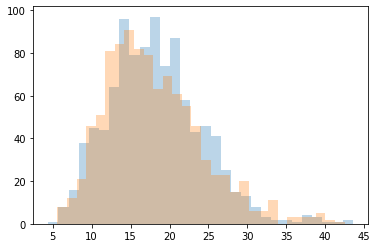

In [167]:
# Comparemos los resultados
print(f'Media te√≥rica de una Gamma(9,2)             : {gamma.stats(moments="m")}')
print(f'Media muestra gamma con random.gammavariates: {np.mean(muestra_g1):4.2f}')
print(f'Media muestra gamma con scipy.stats         : {np.mean(muestra_g2):4.2f}')
plt.hist(muestra_g1, 30, alpha=0.3)
plt.hist(muestra_g2, 30, alpha=0.3)
plt.show()

## <font color='blue'>Creaci√≥n del modelo en python con SimPy</font>

A continuaci√≥n encontrar√°s el c√≥digo que se ha desarrollado para simular el Help Desk propuesto.

In [168]:
# Inicio

# Creamos par√°metros del modelo:
NUM_EMPLOYEES_1 = 2  # N√∫mero de agentes en el proceso #1 del ciclo de trabajo
NUM_EMPLOYEES_2 = 2  # N√∫mero de agentes en el proceso #2 del ciclo de trabajo

# Tiempos de los 2 procesos secuenciales con distribution Gamma
# proceso #1
alpha_1= 9.0
beta_1= 2.0
# proceso #2
alpha_2 = 7.00
beta_2= 3.50

SUPPORT_TIME_1 = alpha_1 * beta_1   # Minutos promedio para el trabajo del proceso #1
SUPPORT_TIME_2 = alpha_2 * beta_2   # Minutos promedio para el trabajo del proceso #2
AVG_CUSTOMER_HOUR = 15              # en promedio llegan X tickets por hora al backlog 
                                    # del HelpDesk (esto es el lambda de poisson)
CUSTOMER_INTERVAL = 60/AVG_CUSTOMER_HOUR # Crea un cliente cada X minutos
SIM_TIME = 60 * 8                     # tiempo de simulaci√≥n en minutos

customers_handled = 0

# Un Help Desk tiene un n√∫mero limitado de agentes (empleados) para atender requerimientos de clientes
# El ciclo de vida del Requerimiento consta de 2 procesos (etapas) secuenciales (proceso #1 y proceso #2)
# Los clientes crean un Requerimiento, este ingresa a un Backlog donde debe esperar a uno de los agentes del primer proceso
# Cuando un Requerimiento consigue disponibilidad de un agente del primer proceso, comienza a ser atendido requerimiento hasta que finaliza el proceso #1
# Una vez finalizada la parte del primer proceso, el requerimiento entra al backlog del segundo proceso
# Cuando un Requerimiento consigue disponibilidad de un agente del segundo proceso, comienza a ser atendido hasta que finaliza el proceso #2 y all√≠ finaliza la atenci√≥n

class HelpDesk(object):
    def __init__(self, env, num_employees_1, num_employees_2, 
                 support_time_1, support_time_2,
                 alpha_1=alpha_1, beta_1=beta_1,
                 alpha_2=alpha_2, beta_2=beta_2,
                 verbose=False):
        self.env = env
        self.staff_1 = simpy.Resource(env, num_employees_1)
        self.staff_2 = simpy.Resource(env, num_employees_2)
        self.support_time_1 = support_time_1
        self.support_time_2 = support_time_2
        self.alpha_1 = alpha_1
        self.beta_1 = beta_1
        self.alpha_2 = alpha_2
        self.beta_2 = beta_2
        self.dist_1 = stats.gamma(a=self.alpha_1, loc=0, scale=self.beta_1)
        self.dist_2 = stats.gamma(a=self.alpha_2, loc=0, scale=self.beta_2)
        self.verbose = verbose

    def support_1(self, customer):
        # El proceso #1 trabaja en la primera parte del Requerimiento
        random_time_1 = self.dist_1.rvs(1)[0]
        #random_time_1 = random.gammavariate(self.alpha, self.beta)
        if self.verbose: print(f"*  Proceso #1 finalizado para Cliente {customer} a las {self.env.now:.2f}")
        yield self.env.timeout(random_time_1)

    def support_2(self, customer):
        # El proceso #2 trabaja en la segunda parte del Requerimiento
        random_time_2 = self.dist_2.rvs(1)[0]
        #random_time_2 = random.gammavariate(self.alpha, self.beta)
        if self.verbose: print(f"** Proceso #2 finalizado para Cliente {customer} a las {self.env.now:.2f}")
        yield self.env.timeout(random_time_2)

def customer(env, name, help_desk, verbose):
    # Los clientes (cada cliente tiene un nombre) crean Requerimientos en el Help Desk y para ser resueltos por agentes
    # Luego los Requerimiento de clientes comienzan a ser atendidos por un Agente del proceso #1, esperan hasta
    # que finaliza la la primera parte del trabajo del proceso #1, luego el requerimiento ingresa al backlog del proceso #2
    # El Requerimiento comienza a ser atendido por un Agente del proceso #2, los clientes esperan hasta que finaliza la segunda parte
    # del trabajo del proceso #2, y luego el Requerimiento finaliza por completo, saliendo del Help Desk (para no volver de nuevo..)  
    
    arrival_time = env.now # guarda el minuto de creaci√≥n del Requerimiento del cliente
    arrival_times.append(arrival_time) # calcula el tiempo en que ingresa ticket al backlog
    global customers_handled
    if verbose: print(f"Cliente {name} ingresa requerimiento al Backlog #1 a las {env.now:.2f}")
    with help_desk.staff_1.request() as request:
        yield request
        # Cliente se dirije a ser atendido por un primer agente
        if verbose: print(f"Cliente {name} comienza a ser atendido su requerimiento por el proceso #1 a las {env.now:.2f}")
        start_support_time_1 = env.now # guarda el minuto en que se inicia la atenci√≥n del cliente 
        wait_times_1.append(env.now - arrival_time) #c alcula el tiempo de espera en la cola 1
        
        yield env.process(help_desk.support_1(name))
        # Cliente sale del primer proceso
        if verbose: print(f"Cliente {name} su requerimiento finaliza el proceso #1 a las {env.now:.2f}")      
        support_times_1.append(env.now - start_support_time_1) #calcula el tiempo de atenci√≥n del proceso #1

    if verbose: print(f"Cliente {name} su requerimiento ingresa al Backlog #2 a las {env.now:.2f}!")
    with help_desk.staff_2.request() as request:
        yield request
        # Cliente se dirije a ser atendido por un segundo agente        
        start_support_time_2 = env.now # guarda el minuto en que se inicia la atenci√≥n del cliente 
        if verbose: print(f"Cliente {name} comienza a ser atendido su requerimiento por el proceso #2 a las {start_support_time_2:.2f}")
        
        yield env.process(help_desk.support_2(name))
        # Cliente sale del segundo proceso y finaliza la atenci√≥n
        if verbose: print(f"Cliente {name} su requerimiento finaliza el proceso #2 y se cierra ticket a las {env.now:.2f}")
        customers_handled += 1       
        support_times_2.append(env.now - start_support_time_2) # calcula el tiempo de atenci√≥n del proceso #2
        total_times.append(env.now - arrival_time) # calcula el tiempo total (todo el proceso de atenci√≥n)

def setup(env, num_employees_1, num_employees_2, support_time_1, support_time_2, customer_interval, verbose=False):
    """
    Crea un Help Desk, un n√∫mero inicial de clientes y luego se mantendr√° 
    creando clientes cada "CUSTOMER_INTERVAL" minutos
    """
    # Crea una instancia del Help Desk
    help_desk = HelpDesk(env, num_employees_1, num_employees_2, support_time_1, support_time_2, verbose=verbose)

    # Crea 5 clientes iniciales
    for i in range(1, 2):
        env.process(customer(env, i, help_desk, verbose=verbose))

    # Crea m√°s clientes mientras la simulaci√≥n est√° corriendo
    while True:
        yield env.timeout(stats.expon.rvs(loc=0, scale=(customer_interval), size=1)[0])
        i += 1
        env.process(customer(env, i, help_desk, verbose=verbose))

## <font color='blue'> Ejecuci√≥n de una corrida</font>
En esta ejecuci√≥n activaremos las salidas impresas (`verbose=True`) de a simulaci√≥n.

In [169]:
# Setup e inicio de la simulaci√≥n
print("Iniciando la simulaci√≥n del Help Desk \n")

# Crear listas para almacenar datasets y su posterior an√°lisis de resultados
arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

RANDOM_SEED = 2 # fijar una semilla para correr 1 replica reproducible

t0 = time()
print(f"Se inicia la Simulaci√≥n del Help Desk - por {SIM_TIME} minutos")
#random.seed(RANDOM_SEED)  #esto nos ayudar√° a reproducir los resultados
np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

# Crea el entorno de simulaci√≥n e inicia el proceso setup
env = simpy.Environment()
env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=True))

# Ejecuta!
env.run(until=SIM_TIME)

print(f"\nClientes atendidos: {customers_handled}")
print(f"\nTiempo total de simulaci√≥n: {(time() - t0):6.4f} segundos")

Iniciando la simulaci√≥n del Help Desk 

Se inicia la Simulaci√≥n del Help Desk - por 480 minutos
Cliente 1 ingresa requerimiento al Backlog #1 a las 0.00
Cliente 1 comienza a ser atendido su requerimiento por el proceso #1 a las 0.00
*  Proceso #1 finalizado para Cliente 1 a las 0.00
Cliente 2 ingresa requerimiento al Backlog #1 a las 2.29
Cliente 2 comienza a ser atendido su requerimiento por el proceso #1 a las 2.29
*  Proceso #1 finalizado para Cliente 2 a las 2.29
Cliente 3 ingresa requerimiento al Backlog #1 a las 4.47
Cliente 4 ingresa requerimiento al Backlog #1 a las 5.39
Cliente 5 ingresa requerimiento al Backlog #1 a las 9.25
Cliente 6 ingresa requerimiento al Backlog #1 a las 10.68
Cliente 7 ingresa requerimiento al Backlog #1 a las 11.92
Cliente 8 ingresa requerimiento al Backlog #1 a las 15.80
Cliente 2 su requerimiento finaliza el proceso #1 a las 17.19
Cliente 2 su requerimiento ingresa al Backlog #2 a las 17.19!
Cliente 2 comienza a ser atendido su requerimiento por el

In [170]:
# Respuestas
NA = customers_handled / len(arrival_times) # Nivel de atenci√≥n
print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
print(f"Nivel de atenci√≥n:             {NA:5.3f}") # Nivel atenci√≥n
print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 

Cantidad de tickets creados:   127
Cantidad de tickets resueltos: 34
Nivel de atenci√≥n:             0.268
Leadtime:                      199.78


##An√°lisis de resultados

Luego de correr un d√≠a laboral, es decir, una r√©plica del modelo durante 8 horas, los resultados que vemos son:

* Cantidad de tickets creados en un d√≠a laboral = **127**
* Cantidad de tickets resueltos en un d√≠a laboral = **34** 
* Nivel de atenci√≥n de un d√≠a laboral = **26.8%**
* Leadtime end to end de un d√≠a laboral = **199.78** minutos

Los datos anteriores son valores agregados del d√≠a laboral simulado, por tanto esconden el detalle. Por ejemplo si quisi√©ramos conocer la distribuci√≥n completa de los tiempos totales de atenci√≥n (que en promedio nos da un leadtime de 199.78 min) tenemos que tomar la lista creada donde est√° el registro de cada ticket resuelto con su tiempo total de atenci√≥n.

En el siguiente gr√°fico podremos apreciar todo este detalle con los **34** tiempos totales de atenci√≥n:

Leadtime (promedio de tiempo total): 199.784 minutos
Desv. std tiempo total: 104.751 minutos
n:  34


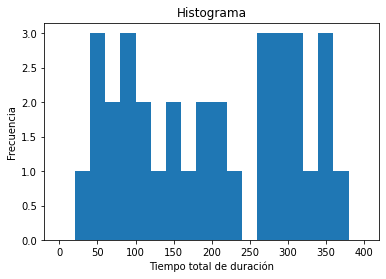

Tiempo total m√≠nimo: 38.608 minutos
Tiempo total m√°ximo: 360.935 minutos


In [171]:
# Graficar histograma de tiempos totales de atenci√≥n

print(f'Leadtime (promedio de tiempo total): {np.mean(total_times):5.3f} minutos')
print(f'Desv. std tiempo total: {np.std(total_times):5.3f} minutos')
print('n: ', np.size(total_times))

plt.hist(total_times, bins=20, range=(0, 400))
plt.ylabel('Frecuencia')
plt.xlabel('Tiempo total de duraci√≥n')
plt.title('Histograma')
plt.show()

print(f'Tiempo total m√≠nimo: {np.min(total_times):5.3f} minutos')
print(f'Tiempo total m√°ximo: {np.max(total_times):5.3f} minutos')

Como podemos ver, nuestro modelo, al considerar la aleatoriedad de los factores incorporados en el modelo, nos permite simular situaciones m√°s realistas, las cuales tienen una infinidad de factores que condicionan su no-linealidad. Por esta raz√≥n podemos ver tickets con tiempos totales muy bajos cercanos a 38 minutos, y otros extremos por la derecha cercanos a los 360 minutos. Por esta raz√≥n los modelos lineales basados en valores promedios y constantes, entregan resultados que normalmente subestiman la realidad y en consecuencia no predicen correctamente las respuestas del sistema modelado.

En el siguiente gr√°fico hemos creado un run chart para ver c√≥mo evolucionan los tiempos totales de los tickets. Claramente podemos ver la tendencia al alza, lo que es muy preocupante, ya que nos indica que si la jornada tuviera m√°s de 8 horas (recordar que la simulaci√≥n es de 8 horas), los tiempos seguir√≠an subiendo, y con ello el Leadtime (promedio de tiempos totales). Claramente este sistema de trabajo se encuentra desbalanceado.



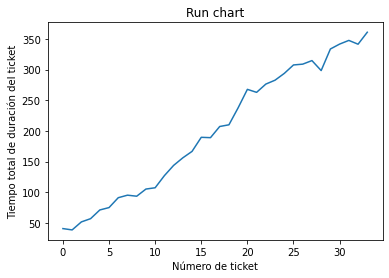

In [172]:
# Graficar run chart
plt.plot(total_times)
plt.ylabel('Tiempo total de duraci√≥n del ticket')
plt.xlabel('N√∫mero de ticket')
plt.title('Run chart')
plt.show()

Recordemos que la simulaci√≥n corrida anteriormente fue solo una, y como estamos en la presencia de un modelo probabil√≠stico, tener solo una r√©plica para an√°lisis y toma de decisiones, es muy riesgoso. La soluci√≥n sugerida aqu√≠ es correr varias simulaciones, un buen n√∫mero es 30 o m√°s (regla de pulgar), y con sus respuestas construir histogramas y calcular intervalos, que nos entreguen mayor confiabilidad de los resultados obtenidos.

A continuaci√≥n presentaremos el an√°lisis de resultados luego de correr 300 veces el modelo de situaci√≥n inicial. Recordemos que el modelo inicial cuenta con 2 agentes en __Proceso #1__ y otros 2 agentes en el __Proceso #2__, por tanto en total tiene 4 agentes nuestro Help Desk.


## <font color='blue'>Simulaci√≥n de $n$ corrdidas</font>
Realizaremos una simulaci√≥n de $n=300$ corridas. Esta vez desactivaremos el `verbose` para acelerar el proceso.

In [173]:
# Setup e inicio de la simulaci√≥n con n corridas
print("Iniciando la simulaci√≥n del Help Desk \n")

# Definimos listas vacias para almacenar las listas de resultados de cada corrida
tch = []  # Customes Handled
tat = []  # Arrival times
tNA = []  # N√∫mero de Atenciones
tLT = []  # Leadtime
tST = []  # Support time
tTT = []  # Tiempo total

# N√∫mero de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")
    # Crea el entorno de simulaci√≥n e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atenci√≥n
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atenci√≥n:             {NA:6.4f}") # Nivel atenci√≥n
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    tTT.append(total_times)
    print(f"\nTiempo total de simulaci√≥n {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulaci√≥n: {(time() - t0):4.2f} segundos")

Iniciando la simulaci√≥n del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            34
Cantidad de tickets creados:   127
Cantidad de tickets resueltos: 34
Nivel de atenci√≥n:             0.2677
Leadtime:                      199.78

Tiempo total de simulaci√≥n 0: 0.08 segundos

SIMULACION 1

Clientes atendidos:            34
Cantidad de tickets creados:   119
Cantidad de tickets resueltos: 34
Nivel de atenci√≥n:             0.2857
Leadtime:                      210.69

Tiempo total de simulaci√≥n 1: 0.04 segundos

SIMULACION 2

Clientes atendidos:            41
Cantidad de tickets creados:   129
Cantidad de tickets resueltos: 41
Nivel de atenci√≥n:             0.3178
Leadtime:                      193.61

Tiempo total de simulaci√≥n 2: 0.05 segundos

SIMULACION 3

Clientes atendidos:            36
Cantidad de tickets creados:   118
Cantidad de tickets resueltos: 36
Nivel de atenci√≥n:             0.3051
Leadtime:                      199.19

Tiempo total de simulaci√≥n 3: 0.05 segundos

SIMULACION 4

Clientes atendidos:  

### An√°lisis de Resultados Modelo situaci√≥n inicial con 4 agentes (2 + 2)

* Cantidad agentes en proceso N¬∞ 1 = **2**
* Cantidad agentes en proceso N¬∞ 2 = **2**

####Cantidad de tickets creados en un d√≠a laboral

Media               : 121.017
Mediana             : 120.000
Desviaci√≥n est√°ndar : 10.756
Con un 0.9 de Nivel de confianza el intervalo est√° entre: 103.32 y 138.71
Con un 0.9 de Nivel de confianza el intervalo est√° entre: 103.00 y 139.00


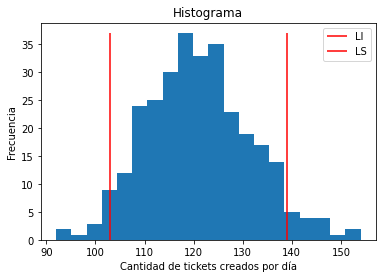

In [174]:
# Lista tat "cantidad de tickets creados" luego de las 300 r√©plicas 

q_creados_2_2 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_2_2):5.3f}')
print(f'Mediana             : {np.median(q_creados_2_2):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(q_creados_2_2):5.3f}')

# c√°lculo intervalos
# aplicando distribuci√≥n Normal
alpha = 0.10
NC = 1 - alpha # nivel de confianza
Z = stats.norm.ppf(1-(alpha)/2)
LI = np.mean(q_creados_2_2) - ( Z * np.std(q_creados_2_2))
LS = np.mean(q_creados_2_2) + ( Z * np.std(q_creados_2_2))
print(f"Con un {NC} de Nivel de confianza el intervalo est√° entre: {LI:6.2f} y {LS:6.2f}")
# aplicando Poisson (dado que es una variable discreta)
LI_p = stats.poisson(np.mean(q_creados_2_2)).ppf(alpha/2)
LS_p = stats.poisson(np.mean(q_creados_2_2)).ppf(1-alpha/2)
print(f"Con un {NC} de Nivel de confianza el intervalo est√° entre: {LI_p:6.2f} y {LS_p:6.2f}")

# graficando
f, b, i = plt.hist(q_creados_2_2, bins=20)
plt.vlines(ymin=0, ymax=max(f), x=LI_p,  colors='r', label='LI')
plt.vlines(ymin=0, ymax=max(f), x=LS_p,  colors='r', label='LS')
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets creados por d√≠a')
plt.title('Histograma')
plt.legend()
plt.show()


El an√°lisis arroj√≥ que en promedio un d√≠a laboral recibir√° 121 tickets, y con una seguridad del 90% podemos concluir que la cantidad de tickets creados por d√≠a estar√° entre 103.32 y 138.71.

Recordemos que el lambda definido al inicio del modelamiento era de 15 tickets por hora, si hubi√©semos modelado el Help Desk de forma determin√≠stica siempre tendr√≠amos 120 tickets por d√≠a (8 horas x 15 ticket/hora). La probabilidad de que ocurra esta situaci√≥n es cercana a un 3.6%, lo que hubiese generado an√°lisis y conclusiones err√≥neas.



In [175]:
# probabilidad de tener en un d√≠a 120 tickets
prob_120= stats.poisson(np.mean(q_creados_2_2)).pmf(120)
print(F"Probabilidad de tener en un d√≠a 120 tickets: {prob_120:6.4f}")

Probabilidad de tener en un d√≠a 120 tickets: 0.0362


####Cantidad de tickets resueltos en un d√≠a laboral

Media               : 36.753
Mediana             : 37.000
Desviaci√≥n est√°ndar : 2.383
Con un 0.9 de Nivel de confianza el intervalo est√° entre:  32.83 y  40.67


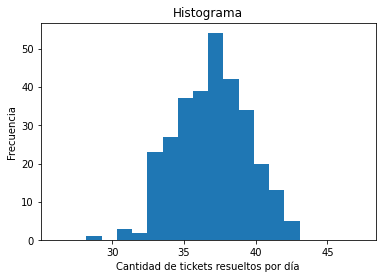

valor m√≠nimo:  29
valor m√°ximo:  43


In [176]:
# Lista tch "cantidad de tickets resueltos" luego de las 300 r√©plicas 

q_resueltos_2_2 = tch
print(f'Media               : {np.mean(q_resueltos_2_2):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_2_2):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(q_resueltos_2_2):5.3f}')

# calculo intervalos
# aplicando Normal
alpha = 0.10
NC = 1 - alpha # nivel de confianza
Z = stats.norm.ppf(1-(alpha)/2)
LI = np.mean(q_resueltos_2_2) - ( Z * np.std(q_resueltos_2_2))
LS = np.mean(q_resueltos_2_2) + ( Z * np.std(q_resueltos_2_2))
print(f"Con un {NC} de Nivel de confianza el intervalo est√° entre: {LI:6.2f} y {LS:6.2f}")

plt.hist(q_resueltos_2_2, bins=20, range=(min(q_resueltos_2_2)*0.9, max(q_resueltos_2_2)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets resueltos por d√≠a')
plt.title('Histograma')
plt.show()

#calculo de min y max
print('valor m√≠nimo: ', np.min(q_resueltos_2_2))
print('valor m√°ximo: ', np.max(q_resueltos_2_2))

El an√°lisis arroj√≥ que en promedio en un d√≠a laboral se finalizar√°n/solucionar√°n 36 tickets, y con una seguridad del 90% podemos concluir que la cantidad de tickets resueltos por d√≠a estar√° entre 32 y 40.

####Nivel de atenci√≥n de un d√≠a laboral

Media               : 0.306
Mediana             : 0.307
Desviaci√≥n est√°ndar : 0.032
Con un 0.9 de Nivel de confianza el intervalo est√° entre:   0.25 y   0.36


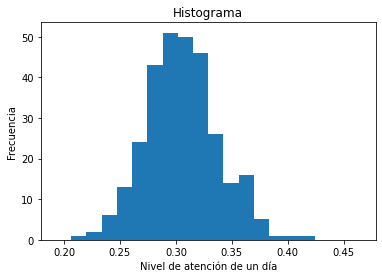

In [177]:
# Lista tNA "nivel de atenci√≥n" luego de las 300 r√©plicas 

nivel_atencion_2_2 = tNA
print(f'Media               : {np.mean(nivel_atencion_2_2):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_2_2):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(nivel_atencion_2_2):5.3f}')

# C√°lculo intervalos
# Aplicando Normal
alpha = 0.10
NC = 1 - alpha #nivel de confianza
Z = stats.norm.ppf(1-(alpha)/2)
LI = np.mean(nivel_atencion_2_2) - ( Z * np.std(nivel_atencion_2_2))
LS = np.mean(nivel_atencion_2_2) + ( Z * np.std(nivel_atencion_2_2))
print(f"Con un {NC} de Nivel de confianza el intervalo est√° entre: {LI:6.2f} y {LS:6.2f}")

plt.hist(nivel_atencion_2_2, bins=20, range=(min(nivel_atencion_2_2)*0.9, max(nivel_atencion_2_2)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Nivel de atenci√≥n de un d√≠a')
plt.title('Histograma')
plt.show()

El an√°lisis arroj√≥ que en promedio en un d√≠a laboral se podr√°n resolver el 30.6% de los tickets recibidos, y con una seguridad del 90% podemos concluir que  el nivel de atenci√≥n diario estar√° entre 25% y 36%.

####Leadtime end to end de un d√≠a laboral

Media               : 185.016
Mediana             : 184.414
Desviaci√≥n est√°ndar : 16.934
Con un 0.9 de Nivel de confianza el intervalo est√° entre: 157.21 y 212.82


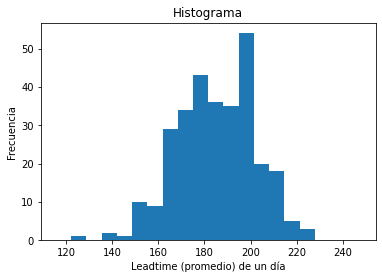

In [178]:
# Lista tlt "leadtime" luego de las 30 replicas 

leadtime_2_2 = tLT
print(f'Media               : {np.mean(leadtime_2_2):5.3f}')
print(f'Mediana             : {np.median(leadtime_2_2):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(leadtime_2_2, ddof=1):5.3f}')

# C√°lculo intervalos
# Aplicando Normal
alpha = 0.10
NC = 1 - alpha # nivel de confianza
Z = stats.norm.ppf(1-(alpha)/2)
LI = np.mean(leadtime_2_2) - ( Z * np.std(leadtime_2_2))
LS = np.mean(leadtime_2_2) + ( Z * np.std(leadtime_2_2))
print(f"Con un {NC} de Nivel de confianza el intervalo est√° entre: {LI:6.2f} y {LS:6.2f}")

plt.hist(leadtime_2_2, bins=20, range=(min(leadtime_2_2)*0.9, max(leadtime_2_2)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Leadtime (promedio) de un d√≠a')
plt.title('Histograma')
plt.show()

El an√°lisis arroj√≥ que en promedio la media diaria de tiempos totales de atenci√≥n (leadtime de un d√≠a laboral) es de 185 minutos, y con una seguridad del 90% podemos concluir que la media diaria de tiempos totales de atenci√≥n (leadtime de un d√≠a laboral) estar√° entre 157 y 212 minutos.


Recordemos que el gr√°fico anterior nos muestra la distribuci√≥n de las medias de un d√≠a laboral (8 horas) de los tiempos totales de atenci√≥n de los tickets que si fueron resueltos, por tanto aqu√≠ tendremos c√°lculos de estas medias con muestras de entre 32 y 40 tickets (v√©ase distribuci√≥n de tickets resueltos). Por tanto este gr√°fico nos esconde el detalle de la distribuci√≥n de los tiempos totales de los tickets, para ver este detalle a continuaci√≥n presentaremos un histograma de estos tiempos con las 300 r√©plicas corridas, lo que simular√°n 300 d√≠as de 8 horas, que en promedio resolvieron 36.753 tickets, por esta raz√≥n la muestra de tiempos totales es de 11026 tickets.

Media              : 184.74
Desviaci√≥n est√°ndar: 89.20
n: 11026.00


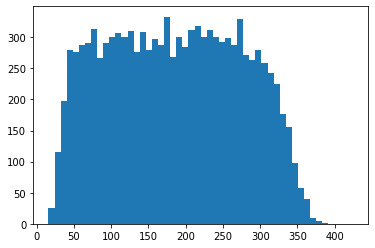

In [179]:
# ANEXO
# Lista  tiempos totales (end to end) creado a partir los casos generados en 300 r√©plicas

tiempos_totales = [val for sublist in tTT for val in  sublist]
print(f"Media              : {np.mean(tiempos_totales):4.2f}")
print(f"Desviaci√≥n est√°ndar: {np.std(tiempos_totales):4.2f}")
print(f"n: {np.size(tiempos_totales):4.2f}")
plt.hist(tiempos_totales, bins=50, range=(min(tiempos_totales)*0.9, max(tiempos_totales)*1.1))
plt.show()

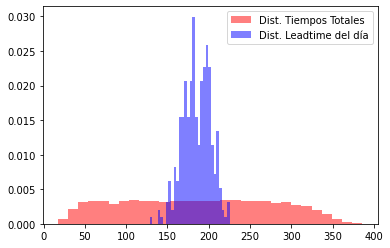

In [180]:
#Graficando en el mismo plano cartesiano la distribuci√≥n de los 300 leadtime diarios y
#la distribuci√≥n de los 11026 tickets

plt.hist(tiempos_totales, bins=30, density=True, color='r', alpha=0.5, label="Dist. Tiempos Totales")
plt.hist(leadtime_2_2, bins=30, density=True, color='b', alpha=0.5, label="Dist. Leadtime del d√≠a")
plt.legend()
plt.show()

Es evidente que la distribuci√≥n de los tiempos totales de los tickets tiene mayor variabilidad que la de las medias diarias, adem√°s tiene una forma platic√∫rtica en comparaci√≥n con las medias diarias (leadtime de un d√≠a laboral).

La explicaci√≥n al fen√≥meno anterior la podemos encontrar en el Teorema del L√≠mite Central (TLC), la que nos dice que independiente de la distribuci√≥n que tenga la variable medida en los individuos objetos de estudio, si tomamos de esta poblaci√≥n de individuos muestras grandes, y luego calculamos a estas muestras sus medias muestrales, est√°s medias muestrales tendr√°n una distribuci√≥n normal.

# <font color='blue'>Desaf√≠o de negocio</font>

Vamos a imaginar que el negocio y sus clientes se encuentran insatisfechos con los resultados que ha exhibido el Help Desk durante los √∫ltimo meses, esto porque los indicadores monitoreados no cumplen las expectativas planteadas al inicio de este servicio.

Los indicadores m√°s relevantes para este servicio son 2:

1. Nivel de atenci√≥n de un d√≠a laboral.
2. Leadtime (end to end) de un d√≠a laboral. 

Ambos se encuentran fuera del target definido de > 85% para el primero y < 60 minutos para el segundo.

Actualmente el Help Desk tiene el siguiente rendimiento promedio diario, calculado a partir de los indicadores diarios de los √∫ltimos 30 d√≠as:

* Nivel de atenci√≥n de un d√≠a laboral = 29%
* Leadtime (end to end) de un d√≠a laboral = 184 minutos ($\sigma= 16$ min)

Del An√°lisis de resultados del modelo inicial podemos apreciar que estos 2 indicadores (29% y 184 min), se encuentran contenidos en el intervalo de confianza de 90%. Por tanto podemos concluir que el modelo predice de buena forma el rendimiento **diario** del sistema de trabajo.

**Test de hip√≥tesis de 1 muestra**

Otra manera para validar si el modelo predice bien o tiene buen ajuste,  ser√≠a por medio de un test de hip√≥tesis para la media de 1 muestra, el que ser√° ejecutado aplicando la prueba Z de 1 muestra v/s un target, esto debido a que tenemos m√°s de 30 r√©plicas.

La prueba de hip√≥tesis ser√° planteada de la siguiente forma:

* $H_0$: La media de "leadtime diario" es igual a 184 minutos
* $H_1$: La media de "leadtime diario" es diferente a 184 minutos

En t√©rminos simples lo que vamos a evaluar aqu√≠ es revisar si es que la media de los 300 'Leadtime diarios" generados a partir de los datos de nuestras simulaciones, se situa entre 2 l√≠mites cr√≠ticos, si esto ocurre la media de "leadtime diarios" caer√≠a en zona de no rechazo de $H_0$, de lo contario se rechazar√≠a la $H_0$.

Estos l√≠mites son:

$$LI = 184 - 1.96* {\frac{16}{\sqrt{300}}} = 182.19 $$ 
$$LS = 184 + 1.96* {\frac{16}{\sqrt{300}}} = 185.81 $$ 

Veamos en el siguiente procedimiento la operaci√≥n completa de un **an√°lisis post-hoc** para evaluar nuestro Test de hip√≥tesis, considerando un nivel de significancia (Error tipo I) de 0.05.

In [181]:
# Pasos
# 1) Cargamos data l√≠nea base (poblaci√≥n)
Mu = 184 #minutos
Sigma = 16 #minutos

# 2) Cargar datos de la muestra
n = np.size(leadtime_2_2) #tama√±o de la muestra
xbar = np.mean(leadtime_2_2) #media de la muestra
S = np.std(leadtime_2_2, ddof=1) # desv. std insesgada no es necesaria utilizarla dado que se conoce Sigma


# 3) Determinar el nivel de significancia de la prueba
alpha = 0.05

# 4) Definir hip√≥tesis a contrastar (prueba bilateral - 2 colas)
#    H0:   Mu = 184
#    H1:   Mu ‚â†  184

# regla decisi√≥n (2 colas)
#    no rechazar H0 si: -Zcritico <= Z <= Z cr√≠tico
#    rechazar H0 si:  Z < -Zcritico  o  Z > Zcritico  

# 5) Determinar el valor cr√≠tico de Z
Zcritico = stats.norm.ppf(1 - (alpha/2))# 2 colas, en esta forma en Python encontramos el valor critico en el Z-test.
print(f'Z cr√≠tico: {Zcritico: 4.3f}')

# 5.1) Calcular el valor en minutos correspondiente al Z cr√≠tico
valor_minutos_zcritico_izquierda = stats.norm(Mu, Sigma/np.sqrt(n)).ppf(alpha/2) # buscar valor cola izquierda
valor_minutos_zcritico_derecha = stats.norm(Mu, Sigma/np.sqrt(n)).ppf(1-alpha/2) # buscar valor cola derecha
print(f"Valor media para Z cr√≠tico por izquierda: {valor_minutos_zcritico_izquierda: 4.3f}")
print(f"Valor media para Z cr√≠tico por derechaa: {valor_minutos_zcritico_derecha: 4.3f}")

Z cr√≠tico:  1.960
Valor media para Z cr√≠tico por izquierda:  182.189
Valor media para Z cr√≠tico por derechaa:  185.811


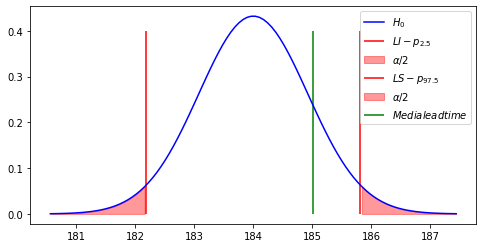

In [182]:
# visualizando la distribuci√≥n de las medias muestrales cuando el n=300 
# y el l√≠mite cr√≠tico de Rechazo H0

# proyectar distribuci√≥n H0
muestral_z = stats.norm(Mu, Sigma / np.sqrt(n))
x_z = np.linspace(muestral_z.ppf(0.0001), muestral_z.ppf(0.9999), 100)
pdf_z = muestral_z.pdf(x_z) # funci√≥n densidad probabilidad

plt.figure(figsize=(8, 4)) # tama√±o gr√°fico
plt.plot(x_z, pdf_z, "b", label='$H_0$') # medias H0
plt.vlines(ymin=0, ymax=0.4, x=valor_minutos_zcritico_izquierda,  colors='r', label='$LI - p_{2.5}$')
# Fill de alfa (Error tipo I)
plt.fill_between(x_z, pdf_z, 
                 where = x_z <= valor_minutos_zcritico_izquierda,
                 color='r', alpha=0.4, label=r'$\alpha/2$')

plt.vlines(ymin=0, ymax=0.4, x=valor_minutos_zcritico_derecha,  colors='r', label='$LS - p_{97.5}$')
# Fill de alfa (Error tipo I)
plt.fill_between(x_z, pdf_z, 
                 where = x_z >= valor_minutos_zcritico_derecha,
                 color='r', alpha=0.4, label=r'$\alpha/2$')
plt.vlines(ymin=0, ymax=0.4, x=xbar,  colors='g', label='$Media leadtime$')
plt.legend()
plt.show()

Para esta prueba de Hip√≥tesis, como el valor de media muestral obtenido con las 300 replicas fue de "Media de leadtime diarios = 185.016 minutos", cifra que se situa entre los l√≠mites cr√≠ticos, no se rechaza la ùêª0 (Hip√≥tesis nula).  Luego se puede concluir que la ""Media de leadtime diarios" obtenido por nuestro modelo de simulaci√≥n no tiene una diferencia estad√≠sticamente significativa con la media real, por tanto el modelo predice de buena forma la realidad de la operaci√≥n del Help Desk..

Otra forma de evaluar este paso es calculando el valor-p (p-value), si este valor es menor al Nivel de significancia establecido, se procede a Rechazar la  ùêª0  (Hip√≥tesis Nula), de lo contrario no se puede rechazar la  ùêª0 .

In [183]:
## 6) Calcular el estad√≠stico Z de prueba.
Z = (xbar - Mu) / (Sigma /np.sqrt(n))
print(f'Z prueba: {Z:5.2f}')

## 7) Calcular el p-value y comparar con el nivel de significancia establecido.
# calcular p-value
pvalue = 2 * (stats.norm.sf(Z) )# Z de prueba se encuentra en cola derecha
print(f'p-value (significancia estad√≠stica): {pvalue:5.2f}') # 2 colas

# Otra forma usando Scipy
pvalue2 = 2* (stats.norm(Mu, Sigma /np.sqrt(n)).sf(xbar)) #2 colas
print(f'p-value con scipy: {pvalue2:5.2f}')

Z prueba:  1.10
p-value (significancia estad√≠stica):  0.27
p-value con scipy:  0.27


**Concluir prueba de hip√≥tesis:**
Como el $Z$ prueba (1.10) se situa entre los $Z$ cr√≠ticos, o como el valor-p ($\text{p-value}=0.27$) es mayor al Nivel de signficancia "alpha" establecido en 0.05, no se rechaza $H_0$. Por tanto se concluye que no existe una diferencia estad√≠sticamente significativa entre la media de leadtime diarios creada a partir de 300 r√©plicas de 1 d√≠a de operaci√≥n y la media real de leadtimes diarios.

Luego podemos concluir que nuestro modelo de simulaci√≥n predice bien el comportamiento real del Help Desk.

Nota: otra forma sencilla de aplicar la prueba de hip√≥tesis de 1 muestra, es por medio de la prueba param√©trica T Student de 1 muestra, que opera de la misma forma que la prueba Z de 1 muestra, a diferencia que T Student est√° dise√±ada principalmente para muestras peque√±as, pero entrega resultados muy similares a la prueba Z cuando las muestras son iguales o mayores a 120 unidades.

En el siguiente c√≥digo apoyado de **Stats** realizaremos la prueba, si el valor-p que se obtenga es menor al nivel de significancia pre-seteado en 0.05, procedemos a rechazar la HO, de lo contrario no podremos rechazarla.

In [184]:
#Test Student de 1 muestra
res = stats.ttest_1samp(a=leadtime_2_2, popmean=184, alternative="two-sided")

#scipy.stats.ttest_1samp(a=nivel_atencion_6_7, popmean, axis=0, nan_policy='propagate', alternative='two-sided', *, keepdims=False)[source]

print(res)

Ttest_1sampResult(statistic=1.0394047314265429, pvalue=0.2994563185693606)


Una vez validado el modelo, se procede a configurar distintos escenarios donde modificaremos los par√°metros de control, en este caso solo ajustaremos:

* cantidad de agentes proceso N¬∞1
* cantidad de agentes proceso N¬∞2

De tal forma que haremos diferentes experimentos, cada uno con 300 r√©plicas, ajustando dichos par√°metros hasta llegar a un escenario que nos permita cumplir las metas de negocio para el Nivel de atenci√≥n y el Leadtime de un d√≠a laboral.

Estos escenarios pueden ser:

* Experimento 1:
 * Cantidad agentes en proceso N¬∞ 1 = **3**
 * Cantidad agentes en proceso N¬∞ 2 = **3**
* Experimento 2:
 * Cantidad agentes en proceso N¬∞ 1 = **4**
 * Cantidad agentes en proceso N¬∞ 2 = **4**
* Experimento 3:
 * Cantidad agentes en proceso N¬∞ 1 = **5**
 * Cantidad agentes en proceso N¬∞ 2 = **5**
* Experimento 4:
 * Cantidad agentes en proceso N¬∞ 1 = **6**
 * Cantidad agentes en proceso N¬∞ 2 = **6**


Luego de realizar todos los experimentos anteriores, es el experimento n√∫mero 4 el que gener√≥ los mejores resultados, es decir, la distribuci√≥n de los indicadores "nivel de atenci√≥n diario" y "leadtime de un d√≠a laboral" se acercan a la meta trazada por la organizaci√≥n.

A continuaci√≥n veamos en particular los resultados de este escenario:



### An√°lisis de Resultados Modelo con 12 agentes (6 + 6)

* Cantidad agentes en proceso N¬∞ 1 = **6**
* Cantidad agentes en proceso N¬∞ 2 = **6**

In [185]:
# Setup e inicio de la simulaci√≥n con n corridas
print("Iniciando la simulaci√≥n del Help Desk \n")

# Definimos listas vacias para almacenar la lista de resultados de cada corrida
tch = []
tat = []
tNA = []
tLT = []

# N√∫mero de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")
    
    NUM_EMPLOYEES_1 = 6
    NUM_EMPLOYEES_2 = 6

    # Crea el entorno de simulaci√≥n e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atenci√≥n
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atenci√≥n:             {NA:6.4f}") # Nivel atenci√≥n
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    print(f"\nTiempo total de simulaci√≥n {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulaci√≥n: {(time() - t0):4.2f} segundos")

Iniciando la simulaci√≥n del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            103
Cantidad de tickets creados:   132
Cantidad de tickets resueltos: 103
Nivel de atenci√≥n:             0.7803
Leadtime:                      81.09

Tiempo total de simulaci√≥n 0: 0.23 segundos

SIMULACION 1

Clientes atendidos:            108
Cantidad de tickets creados:   135
Cantidad de tickets resueltos: 108
Nivel de atenci√≥n:             0.8000
Leadtime:                      95.03

Tiempo total de simulaci√≥n 1: 0.08 segundos

SIMULACION 2

Clientes atendidos:            109
Cantidad de tickets creados:   148
Cantidad de tickets resueltos: 109
Nivel de atenci√≥n:             0.7365
Leadtime:                      93.91

Tiempo total de simulaci√≥n 2: 0.09 segundos

SIMULACION 3

Clientes atendidos:            98
Cantidad de tickets creados:   125
Cantidad de tickets resueltos: 98
Nivel de atenci√≥n:             0.7840
Leadtime:                      64.86

Tiempo total de simulaci√≥n 3: 0.12 segundos

SIMULACION 4

Clientes atendidos:

####Cantidad de tickets creados en un d√≠a laboral

Media               : 120.957
Mediana             : 121.000
Desviaci√≥n est√°ndar : 11.788


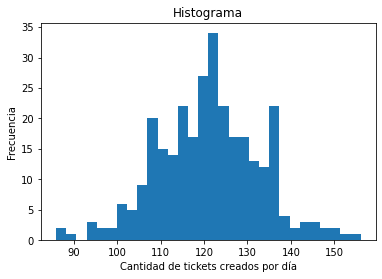

In [186]:
# Lista tat "cantidad de tickets creados" luego de las 300 r√©plicas 

q_creados_6_6 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_6_6):5.3f}')
print(f'Mediana             : {np.median(q_creados_6_6):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(q_creados_6_6):5.3f}')


plt.hist(q_creados_6_6, bins=30)
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets creados por d√≠a')
plt.title('Histograma')
plt.show()

####Cantidad de tickets resueltos en un d√≠a laboral

Media               : 101.637
Mediana             : 102.000
Desviaci√≥n est√°ndar : 6.441


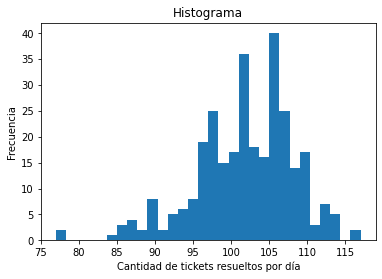

In [187]:
# Lista tch "cantidad de tickets resueltos" luego de las 300 r√©plicas 

q_resueltos_6_6 = tch
print(f'Media               : {np.mean(q_resueltos_6_6):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_6_6):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(q_resueltos_6_6):5.3f}')

plt.hist(q_resueltos_6_6, bins=30)
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets resueltos por d√≠a')
plt.title('Histograma')
plt.show()

####Nivel de atenci√≥n de un d√≠a laboral

Media               : 0.844
Mediana             : 0.849
Desviaci√≥n est√°ndar : 0.054


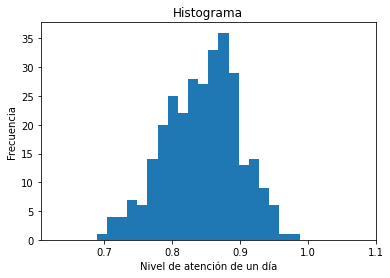

In [188]:
# Lista tNA "nivel de atenci√≥n" luego de las 300 r√©plicas 

nivel_atencion_6_6 = tNA
print(f'Media               : {np.mean(nivel_atencion_6_6):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_6_6):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(nivel_atencion_6_6):5.3f}')

plt.hist(nivel_atencion_6_6, bins=30, range=(min(nivel_atencion_6_6)*0.9, max(nivel_atencion_6_6)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Nivel de atenci√≥n de un d√≠a')
plt.title('Histograma')
plt.show()

####Leadtime end to end de un d√≠a laboral

Media               : 61.682
Mediana             : 58.072
Desviaci√≥n est√°ndar : 13.914


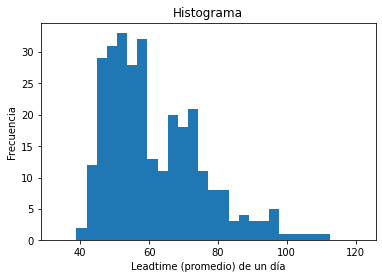

In [189]:
# Lista tLT "leadtime" luego de las 30 replicas 

leadtime_6_6 = tLT
print(f'Media               : {np.mean(leadtime_6_6):5.3f}')
print(f'Mediana             : {np.median(leadtime_6_6):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(leadtime_6_6):5.3f}')

plt.hist(leadtime_6_6, bins=30, range=(min(leadtime_6_6)*0.8, max(leadtime_6_6)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Leadtime (promedio) de un d√≠a')
plt.title('Histograma')
plt.show()

####Conclusi√≥n

Los resultados muestran una mejora significativa al comparar este escenario (6 + 6) V/S la situaci√≥n inicial (2 + 2), esto para los 2 indicadores objeto de optimizaci√≥n. A modo de resumen se comparten los boxplots para ambos indicadores.



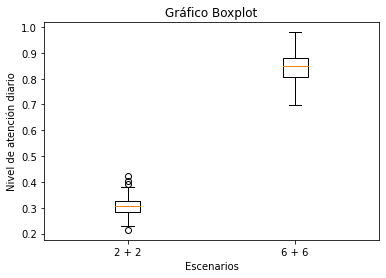

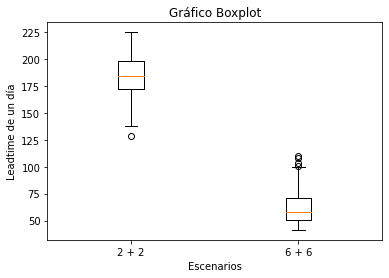

In [190]:
# Graficar boxplots de nivel de atenci√≥n

columns_to_plot = [nivel_atencion_2_2, nivel_atencion_6_6]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atenci√≥n diario')
plt.xlabel('Escenarios')
plt.title('Gr√°fico Boxplot')
plt.xticks([1, 2],
           ["2 + 2", "6 + 6"])
plt.show()

columns_to_plot = [leadtime_2_2,  leadtime_6_6]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un d√≠a')
plt.xlabel('Escenarios')
plt.title('Gr√°fico Boxplot')
plt.xticks([1, 2],
           ["2 + 2", "6 + 6"])
plt.show()

Si bien existe una mejora significativa, a√∫n falta mejorar para llegar a las metas planteadas. Por esta raz√≥n se continuar√° con nuevos experimentos, donde primero incorporaremos 1 nueva persona al Help Desk, primero en el proceso N¬∞1 y luego otro experimento donde esta persona adicional se sumar√° al proceso N¬∞2. Finalmente el √∫ltimo experimento ser√° con 7 personas en el proceso N¬∞1 y 7 personas en el proceso N¬∞2. 

Aqu√≠ la configuraci√≥n:

* Experimento 5:
 * Cantidad agentes en proceso N¬∞ 1 = **7**
 * Cantidad agentes en proceso N¬∞ 2 = **6**
* Experimento 6:
 * Cantidad agentes en proceso N¬∞ 1 = **6**
 * Cantidad agentes en proceso N¬∞ 2 = **7**
* Experimento 7:
 * Cantidad agentes en proceso N¬∞ 1 = **7**
 * Cantidad agentes en proceso N¬∞ 2 = **7**




### An√°lisis de Resultados Modelo con 13 agentes (7 + 6)

* Cantidad agentes en proceso N¬∞ 1 = **7**
* Cantidad agentes en proceso N¬∞ 2 = **6**

####Cantidad de tickets creados en un d√≠a laboral


In [191]:
# Setup e inicio de la simulaci√≥n con n corridas
print("Iniciando la simulaci√≥n del Help Desk \n")

# Definimos listas vacias para almacenar la lista de resultados de cada corrida
tch = []
tat = []
tNA = []
tLT = []

# N√∫mero de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")
    
    NUM_EMPLOYEES_1 = 7
    NUM_EMPLOYEES_2 = 6

    # Crea el entorno de simulaci√≥n e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atenci√≥n
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atenci√≥n:             {NA:6.4f}") # Nivel atenci√≥n
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    print(f"\nTiempo total de simulaci√≥n {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulaci√≥n: {(time() - t0):4.2f} segundos")

Iniciando la simulaci√≥n del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            103
Cantidad de tickets creados:   143
Cantidad de tickets resueltos: 103
Nivel de atenci√≥n:             0.7203
Leadtime:                      86.09

Tiempo total de simulaci√≥n 0: 0.11 segundos

SIMULACION 1

Clientes atendidos:            86
Cantidad de tickets creados:   96
Cantidad de tickets resueltos: 86
Nivel de atenci√≥n:             0.8958
Leadtime:                      44.21

Tiempo total de simulaci√≥n 1: 0.05 segundos

SIMULACION 2

Clientes atendidos:            100
Cantidad de tickets creados:   127
Cantidad de tickets resueltos: 100
Nivel de atenci√≥n:             0.7874
Leadtime:                      76.12

Tiempo total de simulaci√≥n 2: 0.06 segundos

SIMULACION 3

Clientes atendidos:            108
Cantidad de tickets creados:   135
Cantidad de tickets resueltos: 108
Nivel de atenci√≥n:             0.8000
Leadtime:                      74.39

Tiempo total de simulaci√≥n 3: 0.06 segundos

SIMULACION 4

Clientes atendidos: 

Media               : 121.803
Mediana             : 121.000
Desviaci√≥n est√°ndar : 10.793


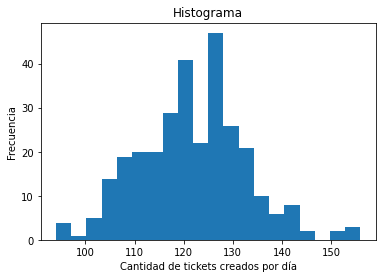

In [192]:
# Lista tat "cantidad de tickets creados" luego de las 300 r√©plicas 

q_creados_7_6 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_7_6):5.3f}')
print(f'Mediana             : {np.median(q_creados_7_6):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(q_creados_7_6):5.3f}')


f, b, i = plt.hist(q_creados_7_6, bins=20)
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets creados por d√≠a')
plt.title('Histograma')
plt.show()

####Cantidad de tickets resueltos en un d√≠a laboral

Media               : 102.130
Mediana             : 102.000
Desviaci√≥n est√°ndar : 5.974


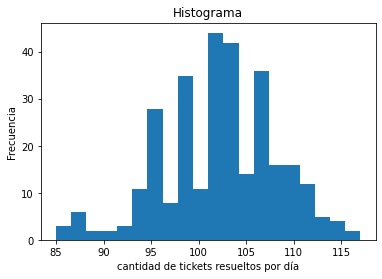

In [193]:
# Lista tch "cantidad de tickets resueltos" luego de las 300 r√©plicas 

q_resueltos_7_6 = tch
print(f'Media               : {np.mean(q_resueltos_7_6):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_7_6):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(q_resueltos_7_6):5.3f}')

plt.hist(q_resueltos_7_6, bins=20)
plt.ylabel('Frecuencia')
plt.xlabel('cantidad de tickets resueltos por d√≠a')
plt.title('Histograma')
plt.show()

####Nivel de atenci√≥n de un d√≠a laboral

Media               : 0.842
Mediana             : 0.848
Desviaci√≥n est√°ndar : 5.974


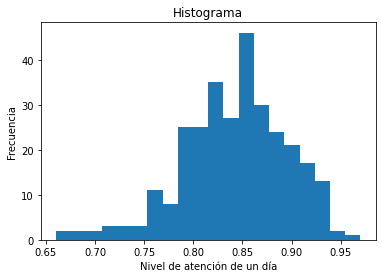

In [194]:
# Lista tNA "nivel de atenci√≥n" luego de las 300 r√©plicas 

nivel_atencion_7_6 = tNA
print(f'Media               : {np.mean(nivel_atencion_7_6):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_7_6):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(q_resueltos_7_6):5.3f}')

plt.hist(nivel_atencion_7_6, bins=20)
plt.ylabel('Frecuencia')
plt.xlabel('Nivel de atenci√≥n de un d√≠a')
plt.title('Histograma')
plt.show()

####Leadtime end to end de un d√≠a laboral

Media               : 60.072
Mediana             : 56.768
Desviaci√≥n est√°ndar : 12.416


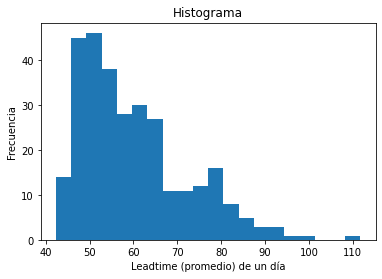

In [195]:
# Lista tlt "leadtime" luego de las 300 replicas 

leadtime_7_6 = tLT
print(f'Media               : {np.mean(leadtime_7_6):5.3f}')
print(f'Mediana             : {np.median(leadtime_7_6):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(leadtime_7_6):5.3f}')

plt.hist(leadtime_7_6, bins=20)
plt.ylabel('Frecuencia')
plt.xlabel('Leadtime (promedio) de un d√≠a')
plt.title('Histograma')
plt.show()

####Conclusiones 
Este escenario que adiciona una nueva persona al Help Desk (al primer proceso), no genera resultados muy diferentes al escenario con 6 y 6 agentes visto anteriormente, y en consecuencia tampoco vemos cumplimiento del target trazado por el negocio.

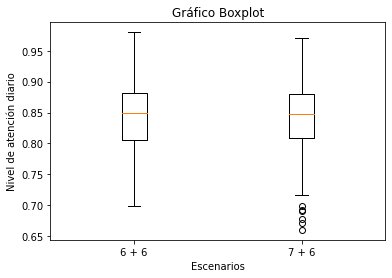

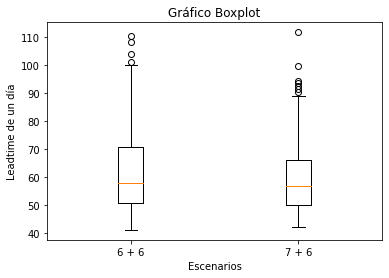

In [196]:
# Graficar boxplots de nivel de atenci√≥n

columns_to_plot = [nivel_atencion_6_6, nivel_atencion_7_6]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atenci√≥n diario')
plt.xlabel('Escenarios')
plt.title('Gr√°fico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "7 + 6"])
plt.show()

columns_to_plot = [leadtime_6_6,  leadtime_7_6]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un d√≠a')
plt.xlabel('Escenarios')
plt.title('Gr√°fico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "7 + 6"])
plt.show()

Otra forma de verificar si los indicadores de ambos escenarios son diferentes o no, es por medio de una prueba de hip√≥tesis, en este caso a modo de ejemplo aplicaremos una prueba de hip√≥tesis param√©trica llamada prueba T Student de 2 muestras independientes, la aplicaremos con la ayuda de **Stats**.

La prueba de hip√≥tesis ser√° planteada de la siguiente forma:

* $H_0$: Las medias de "Nivel de atenci√≥n diario" de ambos escenarios son iguales
* $H_1$: Las medias de "Nivel de atenci√≥n diario" de ambos escenarios no son iguales

Si el valor-p que se obtenga es mayor al nivel de significancia de 0.05, no se rechazar√° la H0, de lo contrario si ser√° rechazada la H0.

In [197]:
#Prueba Parametrica, T-Student 2 muestras independientes, Test de hipotesis diferencia de medias
res = stats.ttest_ind(nivel_atencion_6_6, nivel_atencion_7_6,  equal_var=False, alternative="two-sided")
print(res)


Ttest_indResult(statistic=0.52261670383237, pvalue=0.6014346394289038)


En este caso el valor-p de 0.601 es mayor al nivel de significancia de 0.05, por tanto no se rechaza la H0, luego concluimos que no existen diferencias estad√≠sticamente significativas entre ambas medias de Nivel de atenci√≥n diario.

Si quisi√©ramos calcular la probabilidad de cumplir el target en nivel de atenci√≥n y en leadtime, podr√≠amos hacerlo con el siguiente c√≥digo:

In [198]:
#Nivel de atenci√≥n
#Contador cumplimiento Umbral  

k = 0.85 #umbral nivel de atenci√≥n

count = 0
for i in nivel_atencion_7_6 : 
    if i >= k : 
        count = count + 1

#calculo probabilidad de cumplir target
q_target = count
prob= (count/np.size(nivel_atencion_7_6))

print(f'Prob cumplir target Nivel de atenci√≥n: {prob:5.3f}')

Prob cumplir target Nivel de atenci√≥n: 0.473


In [199]:
#Leadtime
#Contador cumplimiento Umbral  

k = 60 #umbral leadtime

count = 0
for i in leadtime_7_6 : 
    if i <= k : 
        count = count + 1

#calculo probabilidad de cumplir target
q_target = count
prob= (count/np.size(leadtime_7_6))

print(f'Prob cumplir target Leadtime: {prob:5.3f}')

Prob cumplir target Leadtime: 0.580


La probabilidad es muy baja, debemos seguir iterando con otro escenario.

### An√°lisis de Resultados Modelo con 13 agentes (6 + 7)

* Cantidad agentes en proceso N¬∞ 1 = **6**
* Cantidad agentes en proceso N¬∞ 2 = **7**

####Cantidad de tickets creados en un d√≠a laboral

In [200]:
# Setup e inicio de la simulaci√≥n con n corridas
print("Iniciando la simulaci√≥n del Help Desk \n")

# Definimos listas vacias para almacenar la lista de resultados de cada corrida
tch = []
tat = []
tNA = []
tLT = []

# N√∫mero de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")
    
    NUM_EMPLOYEES_1 = 6
    NUM_EMPLOYEES_2 = 7

    # Crea el entorno de simulaci√≥n e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atenci√≥n
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atenci√≥n:             {NA:6.4f}") # Nivel atenci√≥n
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    print(f"\nTiempo total de simulaci√≥n {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulaci√≥n: {(time() - t0):4.2f} segundos")

Iniciando la simulaci√≥n del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            115
Cantidad de tickets creados:   133
Cantidad de tickets resueltos: 115
Nivel de atenci√≥n:             0.8647
Leadtime:                      48.77

Tiempo total de simulaci√≥n 0: 0.11 segundos

SIMULACION 1

Clientes atendidos:            96
Cantidad de tickets creados:   106
Cantidad de tickets resueltos: 96
Nivel de atenci√≥n:             0.9057
Leadtime:                      44.00

Tiempo total de simulaci√≥n 1: 0.08 segundos

SIMULACION 2

Clientes atendidos:            116
Cantidad de tickets creados:   134
Cantidad de tickets resueltos: 116
Nivel de atenci√≥n:             0.8657
Leadtime:                      53.00

Tiempo total de simulaci√≥n 2: 0.07 segundos

SIMULACION 3

Clientes atendidos:            113
Cantidad de tickets creados:   129
Cantidad de tickets resueltos: 113
Nivel de atenci√≥n:             0.8760
Leadtime:                      63.00

Tiempo total de simulaci√≥n 3: 0.07 segundos

SIMULACION 4

Clientes atendidos:

Media               : 121.347
Mediana             : 122.000
Desviaci√≥n est√°ndar : 11.341


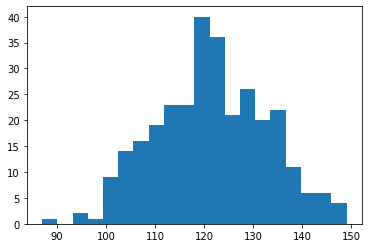

In [201]:
# Lista tat "cantidad de tickets creados" luego de las 300 r√©plicas 

q_creados_6_7 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_6_7):5.3f}')
print(f'Mediana             : {np.median(q_creados_6_7):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(q_creados_6_7):5.3f}')

plt.hist(q_creados_6_7, bins=20)
plt.show()

####Cantidad de tickets resueltos en un d√≠a laboral

Media               : 107.860
Mediana             : 108.000
Desviaci√≥n est√°ndar : 9.187


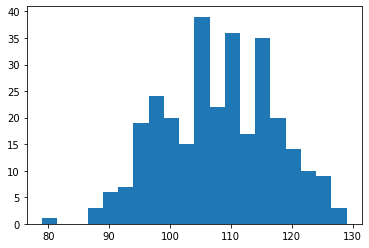

In [202]:
# Lista tch "cantidad de tickets resueltos" luego de las 300 r√©plicas 


q_resueltos_6_7 = tch
print(f'Media               : {np.mean(q_resueltos_6_7):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_6_7):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(q_resueltos_6_7):5.3f}')

plt.hist(q_resueltos_6_7, bins=20)
plt.show()

####Nivel de atenci√≥n de un d√≠a laboral

Media               : 0.890
Mediana             : 0.893
Desviaci√≥n est√°ndar : 0.035


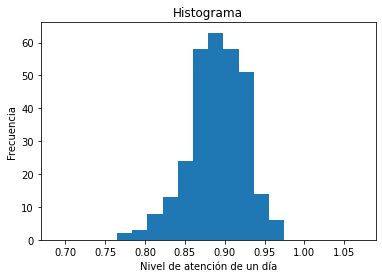

In [203]:
# Lista tNA "nivel de atenci√≥n" luego de las 300 r√©plicas 

nivel_atencion_6_7 = tNA
print(f'Media               : {np.mean(nivel_atencion_6_7):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_6_7):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(nivel_atencion_6_7):5.3f}')

plt.hist(nivel_atencion_6_7, bins=20, range=(min(nivel_atencion_6_7)*0.9, max(nivel_atencion_6_7)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Nivel de atenci√≥n de un d√≠a')
plt.title('Histograma')
plt.show()

####Leadtime end to end de un d√≠a laboral

Media               : 50.363
Mediana             : 48.341
Desviaci√≥n est√°ndar : 7.203


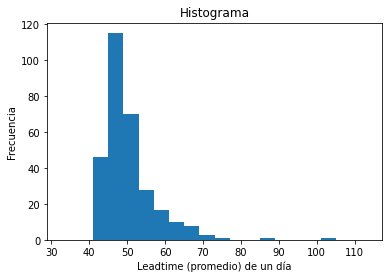

In [204]:
#dataset "leadtime" luego de las 300 replicas 

leadtime_6_7 = tLT
print(f'Media               : {np.mean(leadtime_6_7):5.3f}')
print(f'Mediana             : {np.median(leadtime_6_7):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(leadtime_6_7):5.3f}')

plt.hist(leadtime_6_7, bins=20, range=(min(leadtime_6_7)*0.8, max(leadtime_6_7)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Leadtime (promedio) de un d√≠a')
plt.title('Histograma')
plt.show()

####Conclusiones

Este escenario que adiciona una nueva persona al Help Desk (al segundo proceso), vemos que si genera resultados diferentes al escenario con 6 y 6 agentes visto anteriormente. Estos resultados se acercan y calzan muy bien con las metas trazadas.

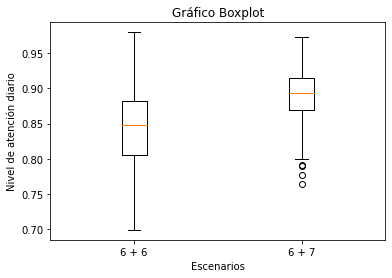

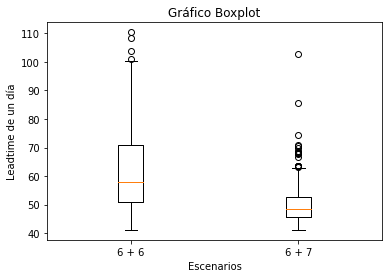

In [205]:
# Graficar boxplots de nivel de atenci√≥n

columns_to_plot = [nivel_atencion_6_6, nivel_atencion_6_7]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atenci√≥n diario')
plt.xlabel('Escenarios')
plt.title('Gr√°fico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "6 + 7"])
plt.show()

columns_to_plot = [leadtime_6_6,  leadtime_6_7]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un d√≠a')
plt.xlabel('Escenarios')
plt.title('Gr√°fico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "6 + 7"])
plt.show()

Otra forma de verificar si los indicadores de ambos escenarios son diferentes o no, es por medio de una prueba de hip√≥tesis, en este caso a modo de ejemplo aplicaremos una prueba de hip√≥tesis param√©trica llamada prueba T Student de 2 muestras independientes, la aplicaremos con la ayuda de **Stats**.

La prueba de hip√≥tesis ser√° planteada de la siguiente forma:

* $H_0$: Las medias de "Nivel de atenci√≥n diario" de ambos escenarios son iguales
* $H_1$: Las medias de "Nivel de atenci√≥n diario" de ambos escenarios no son iguales

Si el valor-p que se obtenga es mayor al nivel de significancia de 0.05, no se rechazar√° la H0, de lo contrario si ser√° rechazada la H0.

In [206]:
#Prueba Parametrica, T-Student 2 muestras independientes, Test de hipotesis diferencia de medias
res = stats.ttest_ind(a=nivel_atencion_6_6, b=nivel_atencion_6_7,  equal_var=False, alternative="two-sided")
print(res)

Ttest_indResult(statistic=-12.232423340606095, pvalue=2.3263944152726876e-30)


En este caso el valor-p de 0.000 es menor al nivel de significancia de 0.05, por tanto se rechaza la H0, luego concluimos que existen diferencias estad√≠sticamente significativas entre ambas medias de Nivel de atenci√≥n diario.

Dicho de otra forma, el promedio de "Nivel de atenci√≥n diario" aumenta de una forma estad√≠sticamente significativa, al pasar del escenario **6+6** personas al escenerio **6+7** personas en el Help Desk.

Esta prueba solo nos indica si las medias son diferentes o no, pero no nos indica si se cumplir√≠a el target definido por la organizaci√≥n, para tal efecto debemos volver a realizar una prueba de hip√≥tesis de 1 muestra frente al target.

**Prueba para Nivel de atenci√≥n**

La prueba de hip√≥tesis ser√° planteada de la siguiente forma:

* $H_0$: La media de "nivel de atenci√≥n diario" es menor o igual a 85%
* $H_1$: La media de "nivel de atenci√≥n diario" es mayor a 85%

In [207]:
#prueba T Student de 1 muestra
res = stats.ttest_1samp(a=nivel_atencion_6_7, popmean=0.85, alternative="greater")

print(res)

Ttest_1sampResult(statistic=19.780874433114292, pvalue=1.456008614961938e-56)


En este caso el p-value es menor al nivel de significancia del 0.05, por tanto se rechaza la H0, luego el promedio de nivel de atenci√≥n diario es mayor al target establecido por el negocio en **85 %**

**Prueba para Leadtime**

La prueba de hip√≥tesis ser√° planteada de la siguiente forma:

* $H_0$: La media de "leadtime diario" es mayor o igual a 60 minutos
* $H_1$: La media de "leadtime diario" es menor a 60 minutos

In [208]:
#prueba T Student de 1 muestra
res = stats.ttest_1samp(a=leadtime_6_7, popmean=60, alternative="less")

print(res)

Ttest_1sampResult(statistic=-23.13590618440414, pvalue=6.851186433217386e-69)


En este caso el p-value es menor al nivel de significancia del 0.05, por tanto se rechaza la H0, luego el promedio de leadtime diario es menor al target establecido por el negocio en **60** minutos.

Si quisi√©ramos calcular la probabilidad de cumplir el target en nivel de atenci√≥n y en leadtime, podr√≠amos hacerlo con el siguiente c√≥digo:

In [209]:
#Nivel de atenci√≥n
#Contador cumplimiento Umbral  

k = 0.85 #umbral nivel de atenci√≥n

count = 0
for i in nivel_atencion_6_7 : 
    if i >= k : 
        count = count + 1

#calculo probabilidad de cumplir target
q_target = count
prob= (count/np.size(nivel_atencion_6_7))

print(f'Prob cumplir target Nivel de atenci√≥n: {prob:5.3f}')

Prob cumplir target Nivel de atenci√≥n: 0.887


In [210]:
#Leadtime
#Contador cumplimiento Umbral  

k = 60 #umbral leadtime

count = 0
for i in leadtime_6_7 : 
    if i <= k : 
        count = count + 1

#calculo probabilidad de cumplir target
q_target = count
prob= (count/np.size(leadtime_6_7))

print(f'Prob cumplir target Leadtime: {prob:5.3f}')

Prob cumplir target Leadtime: 0.900


Una buena seguridad es de 85% o 90%, en este caso ambos cuentan con una probabilidad de cumplirse cercano a 90%.


De todas formas haremos el √∫ltimo experimento, tomaremos este escenario √≥ptimo (6 + 7) y le incorporaremos una nueva persona, pero ahora al primer proceso de tal forma de tener 7 y 7 agentes, veamos si se genera una mejora.

In [211]:
#NOTA: otra forma de calcular probabilidades es asumir la normalidad de las variables

#nivel de atenci√≥n
target_na = 0.85
prob_mayor_85 = stats.norm(np.mean(nivel_atencion_6_7), np.std(nivel_atencion_6_7)).sf(target_na)
print(f'Prob cumplir target Nivel de atenci√≥n: {prob_mayor_85:5.3f}')


#Leadtime
target_lt = 60
prob_menor_60 = stats.norm(np.mean(leadtime_6_7), np.std(leadtime_6_7)).cdf(target_lt)
print(f'Prob cumplir target Leadtime: {prob_menor_60:5.3f}')

Prob cumplir target Nivel de atenci√≥n: 0.874
Prob cumplir target Leadtime: 0.910


### An√°lisis de Resultados Modelo con 14 agentes (7 + 7)

* Cantidad agentes en proceso N¬∞ 1 = **7**
* Cantidad agentes en proceso N¬∞ 2 = **7**

In [212]:
# Setup e inicio de la simulaci√≥n con n corridas
print("Iniciando la simulaci√≥n del Help Desk \n")

# Definimos listas vacias para almacenar la lista de resultados de cada corrida
tch = []
tat = []
tNA = []
tLT = []

# N√∫mero de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")
    
    NUM_EMPLOYEES_1 = 7
    NUM_EMPLOYEES_2 = 7

    # Crea el entorno de simulaci√≥n e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atenci√≥n
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atenci√≥n:             {NA:6.4f}") # Nivel atenci√≥n
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    print(f"\nTiempo total de simulaci√≥n {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulaci√≥n: {(time() - t0):4.2f} segundos")

Iniciando la simulaci√≥n del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            116
Cantidad de tickets creados:   129
Cantidad de tickets resueltos: 116
Nivel de atenci√≥n:             0.8992
Leadtime:                      45.83

Tiempo total de simulaci√≥n 0: 0.12 segundos

SIMULACION 1

Clientes atendidos:            99
Cantidad de tickets creados:   111
Cantidad de tickets resueltos: 99
Nivel de atenci√≥n:             0.8919
Leadtime:                      44.77

Tiempo total de simulaci√≥n 1: 0.07 segundos

SIMULACION 2

Clientes atendidos:            116
Cantidad de tickets creados:   124
Cantidad de tickets resueltos: 116
Nivel de atenci√≥n:             0.9355
Leadtime:                      46.87

Tiempo total de simulaci√≥n 2: 0.06 segundos

SIMULACION 3

Clientes atendidos:            100
Cantidad de tickets creados:   119
Cantidad de tickets resueltos: 100
Nivel de atenci√≥n:             0.8403
Leadtime:                      42.58

Tiempo total de simulaci√≥n 3: 0.06 segundos

SIMULACION 4

Clientes atendidos:

####Cantidad de tickets creados en un d√≠a laboral

Media               : 121.590
Mediana             : 122.000
Desviaci√≥n est√°ndar : 10.780


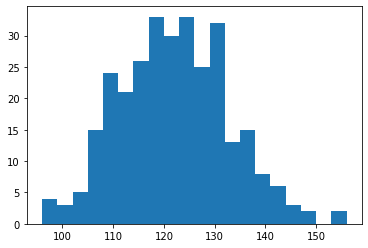

In [213]:
# Lista tat "cantidad de tickets creados" luego de las 300 r√©plicas 

q_creados_7_7 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_7_7):5.3f}')
print(f'Mediana             : {np.median(q_creados_7_7):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(q_creados_7_7):5.3f}')


plt.hist(q_creados_7_7, bins=20)
plt.show()

####Cantidad de tickets resueltos en un d√≠a laboral

Media               : 108.357
Mediana             : 108.000
Desviaci√≥n est√°ndar : 8.895


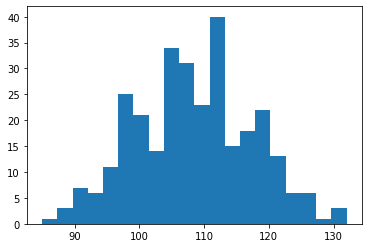

In [214]:
q_resueltos_7_7 = tch
print(f'Media               : {np.mean(q_resueltos_7_7):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_7_7):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(q_resueltos_7_7):5.3f}')

plt.hist(q_resueltos_7_7, bins=20)
plt.show()

####Nivel de atenci√≥n de un d√≠a laboral

Media               : 0.892
Mediana             : 0.894
Desviaci√≥n est√°ndar : 0.033


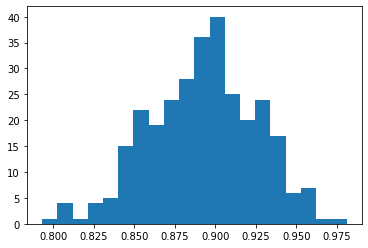

In [215]:
# Lista tNA "nivel de atenci√≥n" luego de las 300 r√©plicas 

nivel_atencion_7_7 = tNA
print(f'Media               : {np.mean(nivel_atencion_7_7):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_7_7):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(nivel_atencion_7_7):5.3f}')

plt.hist(nivel_atencion_7_7, bins=20)
plt.show()

####Leadtime end to end de un d√≠a laboral

Media               : 49.267
Mediana             : 47.706
Desviaci√≥n est√°ndar : 6.429


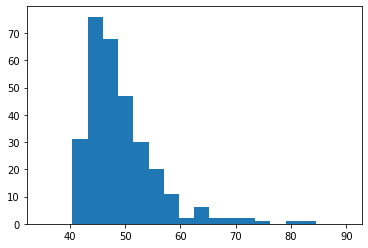

In [216]:
# Lista tLT "leadtime" luego de las 30 replicas 

leadtime_7_7 = tLT
print(f'Media               : {np.mean(leadtime_7_7):5.3f}')
print(f'Mediana             : {np.median(leadtime_7_7):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(leadtime_7_7):5.3f}')

plt.hist(leadtime_7_7, bins=20, range=(35, 90))
plt.show()

####Conclusiones

Al comparar los resultados de este escenario (7+7) V/S el escenario √≥ptimo anterior con 6 + 7 agentes, no vemos diferencias. Por un tema de eficiencia recomendamos el escenario con 6 + 7 agentes.

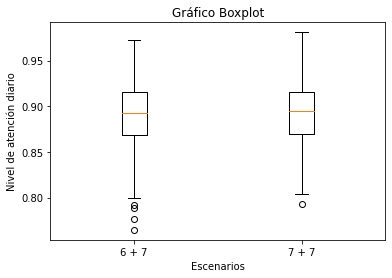

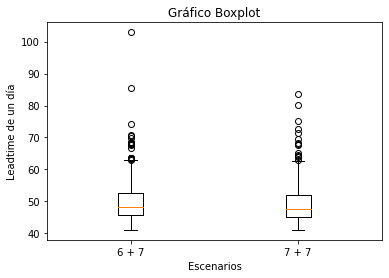

In [217]:
# Graficar boxplots de nivel de atenci√≥n

columns_to_plot = [nivel_atencion_6_7, nivel_atencion_7_7]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atenci√≥n diario')
plt.xlabel('Escenarios')
plt.title('Gr√°fico Boxplot')
plt.xticks([1, 2],
           ["6 + 7", "7 + 7"])
plt.show()

columns_to_plot = [leadtime_6_7,  leadtime_7_7]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un d√≠a')
plt.xlabel('Escenarios')
plt.title('Gr√°fico Boxplot')
plt.xticks([1, 2],
           ["6 + 7", "7 + 7"])
plt.show()

Realicemos una prueba de hip√≥tesis de diferencia de medias para comprobarlo.

La prueba de hip√≥tesis ser√° planteada de la siguiente forma:

* $H_0$: Las medias de "Nivel de atenci√≥n diario" de ambos escenarios son iguales
* $H_1$: Las medias de "Nivel de atenci√≥n diario" de ambos escenarios no son iguales

Si el valor-p que se obtenga es mayor al nivel de significancia de 0.05, no se rechazar√° la H0, de lo contrario si ser√° rechazada la H0.


In [218]:
#Prueba Parametrica, T-Student 2 muestras independientes, Test de hipotesis diferencia de medias
res = stats.ttest_ind(a=nivel_atencion_6_7, b=nivel_atencion_7_7,  equal_var=False, alternative="two-sided")
print(res)

Ttest_indResult(statistic=-0.7297727201143339, pvalue=0.46581601028678365)


En este caso el valor-p obtenido es de 0.46, cifra superior al nivel de significancia de 0.05, por tanto no se puede rechazar la H0. Luego no existe una diferencia estad√≠sticamente significativa entre las medias de Nivel de atenci√≥n diario de ambos escenarios.

Por eficiencia, se recomienda implementar el escenario **6+7** personas en el Help Desk.

Al calcular la probabilidad de cumplir target vemos que este escenario tiene menos capacidad que el anterior con 6 + 7 agentes.

A continuaci√≥n un resumen con todos los escenarios desarrollados:

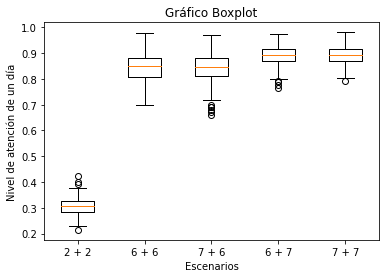

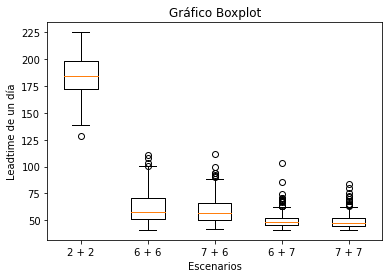

In [219]:
# Boxplot resumen

#Nivel de atenci√≥n
columns_to_plot = [nivel_atencion_2_2, nivel_atencion_6_6, nivel_atencion_7_6, nivel_atencion_6_7, nivel_atencion_7_7]
plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atenci√≥n de un d√≠a')
plt.xlabel('Escenarios')
plt.title('Gr√°fico Boxplot')
plt.xticks([1, 2, 3 , 4, 5],
           ["2 + 2", "6 + 6", "7 + 6", "6 + 7", "7 + 7"])
plt.show()


#Leadtime
columns_to_plot = [leadtime_2_2, leadtime_6_6, leadtime_7_6, leadtime_6_7, leadtime_7_7]
plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un d√≠a')
plt.xlabel('Escenarios')
plt.title('Gr√°fico Boxplot')
plt.xticks([1, 2, 3 , 4, 5],
           ["2 + 2", "6 + 6", "7 + 6", "6 + 7", "7 + 7"])
plt.show()




La invitaci√≥n es a seguir planteando hip√≥tesis y a crear experimentos, por ejemplo:

* ¬øqu√© pasa s√≠ trabajamos con un modelo con 5 + 7 agentes?
* ¬øqu√© pasa si al modelo con 6 + 6 agentes al proceso N¬∞2 le aplicamos una mejora que reduzca la media de ese proceso en 2 minutos ?

o esta que proceder√© a testear:
* ¬øqu√© pasa s√≠ el proceso ahora es m√°s Lean?, lo que significa que los agentes tendr√°n la habilidad de desarrollar de forma aut√≥noma tanto el proceso N¬∞1 como el N¬∞2, es decir, sin tener especialista por proceso, y as√≠ evitar dependencias.


Para esta √∫ltima idea proceder√© a crear un nuevo modelo donde los agentes trabajan de punta a punta (end to end) los requerimientos, mantendr√© la misma variabilidad en el arribo de requerimientos y en los tiempos de proceso N¬∞1 y proceso N¬∞2, pero comenzar√© con 10 agentes en el Help Desk.

###An√°lisis de Resultados Modelo Lean con 10 agentes

* Cantidad agentes en sistema: 10 (multi-skill)

A continuaci√≥n configuraremos el modo Lean del help desk :

In [244]:
#Inicio

# Creamos par√°metros del modelo:
NUM_EMPLOYEES_1 = 10  # N√∫mero de agentes en el servicio Help Desk (multi-skill)


# Tiempos de los 2 procesos secuenciales con distribution Gamma
# proceso #1
alpha_1= 9.0
beta_1= 2.0
# proceso #2
alpha_2 = 7.00
beta_2= 3.50

SUPPORT_TIME_1 = alpha_1 * beta_1   # Minutos promedio para el trabajo del proceso #1
SUPPORT_TIME_2 = alpha_2 * beta_2   # Minutos promedio para el trabajo del proceso #2
AVG_CUSTOMER_HOUR = 15              # en promedio llegan X tickets por hora al backlog 
                                    # del HelpDesk (esto es el lambda de poisson)
CUSTOMER_INTERVAL = 60/AVG_CUSTOMER_HOUR # Crea un cliente cada X minutos
SIM_TIME = 60 * 8                     # tiempo de simulaci√≥n en minutos

customers_handled = 0

# Un Help Desk tiene un n√∫mero limitado de agentes (empleados) para atender requerimientos de clientes
# El ciclo de vida del Requerimiento consta de 2 procesos (etapas) secuenciales (proceso #1 y proceso #2)
# Los clientes crean un Requerimiento, este ingresa a un Backlog donde debe esperar a uno de los agentes del primer proceso
# Cuando un Requerimiento consigue disponibilidad de un agente del primer proceso, comienza a ser atendido requerimiento hasta que finaliza el proceso #1
# Una vez finalizada la parte del primer proceso, el requerimiento entra al backlog del segundo proceso
# Cuando un Requerimiento consigue disponibilidad de un agente del segundo proceso, comienza a ser atendido hasta que finaliza el proceso #2 y all√≠ finaliza la atenci√≥n

class HelpDesk(object):
    def __init__(self, env, num_employees_1, 
                 support_time_1,
                 alpha_1=alpha_1, beta_1=beta_1,
                 alpha_2=alpha_2, beta_2=beta_2,
                 verbose=False):
        self.env = env
        self.staff_1 = simpy.Resource(env, num_employees_1)
        self.support_time_1 = support_time_1
        self.alpha_1 = alpha_1
        self.beta_1 = beta_1
        self.alpha_2 = alpha_2
        self.beta_2 = beta_2
        self.dist_1 = stats.gamma(a=self.alpha_1, loc=0, scale=self.beta_1)
        self.dist_2 = stats.gamma(a=self.alpha_2, loc=0, scale=self.beta_2)
        self.verbose = verbose

    def support_1(self, customer):
        # El proceso #1 trabaja en la primera parte del Requerimiento
        random_time_1 = self.dist_1.rvs(1)[0] + self.dist_2.rvs(1)[0]
        #random_time_1 = random.gammavariate(self.alpha, self.beta)
        if self.verbose: print(f"*  Proceso #1 finalizado para Cliente {customer} a las {self.env.now:.2f}")
        yield self.env.timeout(random_time_1)


def customer(env, name, help_desk, verbose):
    # Los clientes (cada cliente tiene un nombre) crean Requerimientos en el Help Desk y para ser resueltos por agentes
    # Luego los Requerimiento de clientes comienzan a ser atendidos por un Agente del proceso #1, esperan hasta
    # que finaliza la la primera parte del trabajo del proceso #1, luego el requerimiento ingresa al backlog del proceso #2
    # El Requerimiento comienza a ser atendido por un Agente del proceso #2, los clientes esperan hasta que finaliza la segunda parte
    # del trabajo del proceso #2, y luego el Requerimiento finaliza por completo, saliendo del Help Desk (para no volver de nuevo..)  
    
    arrival_time = env.now # guarda el minuto de creaci√≥n del Requerimiento del cliente
    arrival_times.append(arrival_time) # calcula el tiempo en que ingresa ticket al backlog
    global customers_handled
    if verbose: print(f"Cliente {name} ingresa requerimiento al Backlog #1 a las {env.now:.2f}")
    with help_desk.staff_1.request() as request:
        yield request
        # Cliente se dirije a ser atendido por un primer agente
        if verbose: print(f"Cliente {name} comienza a ser atendido su requerimiento por el proceso #1 a las {env.now:.2f}")
        start_support_time_1 = env.now # guarda el minuto en que se inicia la atenci√≥n del cliente 
        wait_times_1.append(env.now - arrival_time) #c alcula el tiempo de espera en la cola 1
        
        yield env.process(help_desk.support_1(name))
        # Cliente sale del primer proceso
        if verbose: print(f"Cliente {name} su requerimiento finaliza el proceso #1 a las {env.now:.2f}")      
        customers_handled += 1   
        support_times_1.append(env.now - start_support_time_1) #calcula el tiempo de atenci√≥n del proceso #1
        total_times.append(env.now - arrival_time) # calcula el tiempo total (todo el proceso de atenci√≥n)

def setup(env, num_employees_1, support_time_1, customer_interval, verbose=False):
    """
    Crea un Help Desk, un n√∫mero inicial de clientes y luego se mantendr√° 
    creando clientes cada "CUSTOMER_INTERVAL" minutos
    """
    # Crea una instancia del Help Desk
    help_desk = HelpDesk(env, num_employees_1, support_time_1, verbose=verbose)

    # Crea 5 clientes iniciales
    for i in range(1, 2):
        env.process(customer(env, i, help_desk, verbose=verbose))

    # Crea m√°s clientes mientras la simulaci√≥n est√° corriendo
    while True:
        yield env.timeout(stats.expon.rvs(loc=0, scale=(customer_interval), size=1)[0])
        i += 1
        env.process(customer(env, i, help_desk, verbose=verbose))

En el siguiente c√≥digo puedes configurar la cantidad de r√©plicas a ejecutar:

In [239]:
# Setup e inicio de la simulaci√≥n con n corridas
print("Iniciando la simulaci√≥n del Help Desk \n")

# Definimos listas vacias para almacenar la lista de resultados de cada corrida
tch = []
tat = []
tNA = []
tLT = []

# N√∫mero de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    #wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    #support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")
    
    NUM_EMPLOYEES_1 = 10

    # Crea el entorno de simulaci√≥n e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, SUPPORT_TIME_1, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atenci√≥n
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atenci√≥n:             {NA:6.4f}") # Nivel atenci√≥n
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    print(f"\nTiempo total de simulaci√≥n {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulaci√≥n: {(time() - t0):4.2f} segundos")

Iniciando la simulaci√≥n del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            96
Cantidad de tickets creados:   113
Cantidad de tickets resueltos: 96
Nivel de atenci√≥n:             0.8496
Leadtime:                      48.28

Tiempo total de simulaci√≥n 0: 0.16 segundos

SIMULACION 1

Clientes atendidos:            109
Cantidad de tickets creados:   122
Cantidad de tickets resueltos: 109
Nivel de atenci√≥n:             0.8934
Leadtime:                      60.12

Tiempo total de simulaci√≥n 1: 0.07 segundos

SIMULACION 2

Clientes atendidos:            96
Cantidad de tickets creados:   130
Cantidad de tickets resueltos: 96
Nivel de atenci√≥n:             0.7385
Leadtime:                      67.61

Tiempo total de simulaci√≥n 2: 0.06 segundos

SIMULACION 3

Clientes atendidos:            110
Cantidad de tickets creados:   139
Cantidad de tickets resueltos: 110
Nivel de atenci√≥n:             0.7914
Leadtime:                      82.43

Tiempo total de simulaci√≥n 3: 0.06 segundos

SIMULACION 4

Clientes atendidos:  

####Cantidad de tickets creados en un d√≠a laboral

Media               : 120.713
Mediana             : 120.000
Desviaci√≥n est√°ndar : 11.433


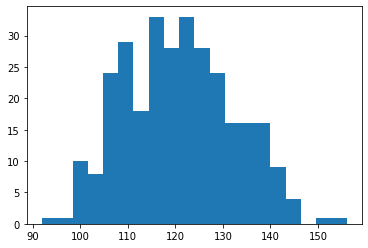

In [240]:
# Lista tat "cantidad de tickets creados" luego de las 300 r√©plicas 

q_creados_10 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_10):5.3f}')
print(f'Mediana             : {np.median(q_creados_10):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(q_creados_10):5.3f}')

plt.hist(q_creados_10, bins=20)
plt.show()

####Cantidad de tickets resueltos en un d√≠a laboral

Media               : 99.767
Mediana             : 101.000
Desviaci√≥n est√°ndar : 5.281


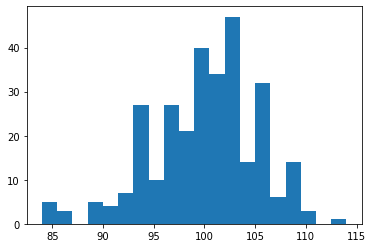

In [241]:
# Lista tch "cantidad de tickets resueltos" luego de las 300 r√©plicas 

q_resueltos_10 = tch
print(f'Media               : {np.mean(q_resueltos_10):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_10):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(q_resueltos_10):5.3f}')

plt.hist(q_resueltos_10, bins=20)
plt.show()

####Nivel de atenci√≥n de un d√≠a laboral

Media               : 0.831
Mediana             : 0.841
Desviaci√≥n est√°ndar : 0.059


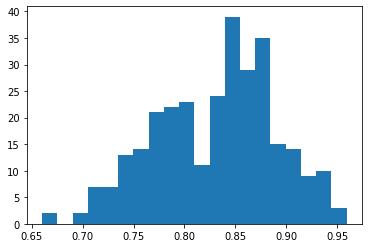

In [242]:
# Lista tNA "nivel de atenci√≥n" luego de las 300 r√©plicas 

nivel_atencion_10 = tNA
print(f'Media               : {np.mean(nivel_atencion_10):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_10):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(nivel_atencion_10):5.3f}')

plt.hist(nivel_atencion_10, bins=20)
plt.show()

####Leadtime end to end de un d√≠a laboral

Media               : 61.994
Mediana             : 58.697
Desviaci√≥n est√°ndar : 14.170


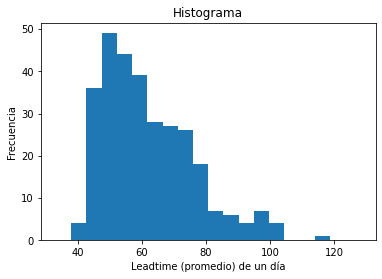

In [243]:
#dataset "leadtime" luego de las 300 replicas 

leadtime_10 = tLT
print(f'Media               : {np.mean(leadtime_10):5.3f}')
print(f'Mediana             : {np.median(leadtime_10):5.3f}')
print(f'Desviaci√≥n est√°ndar : {np.std(leadtime_10):5.3f}')

plt.hist(leadtime_10, bins=20, range=(min(leadtime_10)*0.8, max(leadtime_10)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Leadtime (promedio) de un d√≠a')
plt.title('Histograma')
plt.show()

####Conclusiones

Al analizar los resultados de este escenario, vemos que no cumple de buena forma el target planteado, pero podemos darnos cuenta que sus resultados son muy similares al escenario con procesos especializados con 6 + 6 agentes. La diferencia aqu√≠ radica en los costos asociados, ya que este escenario tendr√≠a los mismos resultados que el modelo con 12 agentes (6 + 6) pero con menores costos, aproximadamente un 17% menos.

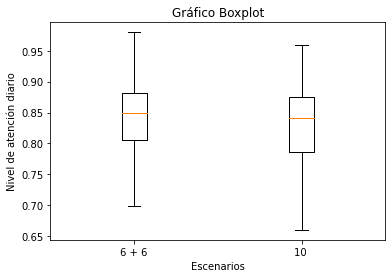

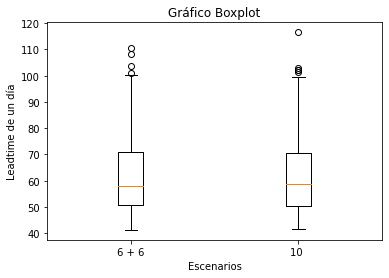

In [245]:
#Graficar boxplots de nivel de atenci√≥n

columns_to_plot = [nivel_atencion_6_6, nivel_atencion_10]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atenci√≥n diario')
plt.xlabel('Escenarios')
plt.title('Gr√°fico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "10 "])
plt.show()

columns_to_plot = [leadtime_6_6,  leadtime_10]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un d√≠a')
plt.xlabel('Escenarios')
plt.title('Gr√°fico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "10 "])
plt.show()

Tendr√≠amos que probar otro escenario con 11 agentes en modo lean y ver si este cumple el target. 

In [ ]:
###ponga aqu√≠ los resultados de su experimento
#

###Cierre

Para finalizar solo recordar que este es solo un ejercicio de ejemplo, hemos dejado muchos factores aleatorios fuera del modelo de simulaci√≥n, as√≠ como respuestas interesantes de evaluar como por ejemplo la utilizaci√≥n, productividad, ingresos por ticket finalizado, premios o multas, entre otros.

Esperamos sea de gran valor y lo puedan poner en pr√°ctica ya sea ejecutando nuevos escenarios, creando m√°s replicas, o ajust√°ndolo a nuevos desaf√≠os o casos de uso.

##Referencias

* Teorema del l√≠mite central  https://en.wikipedia.org/wiki/Central_limit_theorem
* Framework SimPy https://simpy.readthedocs.io/en/latest/
* Simulaci√≥n discreta https://en.wikipedia.org/wiki/Discrete-event_simulation
* Sim call center: https://github.com/robertomoragad/Estadistica/blob/master/Sim_call_center_0_2.ipynb
